# Model fitness on TFA

In [1]:
import itertools
import math
import os
import random
import re
import sys
import tempfile
import time
import warnings

import numpy as np
import networkx as nx
import pyarrow as pa
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import ScalarFormatter
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import scipy.interpolate
import scipy.stats
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.stats.multitest

pd.set_option('display.precision', 2)
%matplotlib inline

## Read in background data

In [2]:
annotation_df = pd.read_csv('../Papers/Mycobacterium_tuberculosis_H37Rv_txt_v5.txt',
    sep='\t', index_col=None, usecols=['Locus', 'Name', 'Function', 'UniProt_AC'])
annotation_df = annotation_df[~annotation_df['Locus'].str.startswith('MTB')]
print(annotation_df.shape)
annotation_df.head()

(4043, 4)


,Locus,Name,Function,UniProt_AC
56,Rv2007c,fdxA,Involved in electron transfer.,P9WNE7
57,Rv3451,cut3,Hydrolysis of cutin (a polyester that forms th...,P9WP39
58,Rv3452,cut4,Hydrolysis of cutin (a polyester that forms th...,O06319
59,Rv2658c,Rv2658c,Unknown,P9WL47
60,Rv2612c,pgsA1,Catalyzes the transfer of a free alcohol (inos...,P9WPG7


In [3]:
v3_network_df = pd.read_csv('../docker/results2/v2/aggregate-mtb_candidate_v3_directed.txt',
    sep='\t', header=None, index_col=None, names=['Regulator', 'Gene', 'Rank', 'Direction', 'Direction_details'])
v3_network_df['Edge'] = v3_network_df['Regulator'].str.cat(v3_network_df['Gene'], sep='_')
print(v3_network_df.shape)
v3_network_df.head()

(68226, 6)


,Regulator,Gene,Rank,Direction,Direction_details,Edge
0,Rv1657,Rv1659,1,up,up/up/up/up/-,Rv1657_Rv1659
1,Rv1657,Rv1658,2,up,up/up/-/-/-,Rv1657_Rv1658
2,Rv3249c,Rv3250c,3,up,up/-/-/-/-,Rv3249c_Rv3250c
3,Rv0081,Rv0085,4,both,up/down/up/-/-,Rv0081_Rv0085
4,Rv3417c,Rv0440,5,up,up/-/-/down/-,Rv3417c_Rv0440


In [4]:
# tweak the constituent dataframes so the labels match the annotation we're using, for as much consistency as possible
# we probably should have done this to the original gene expression datasets before inferring networks, but oh well

# typos/misannotations in TFOE dataset annotation

tfoe_mapping = {
	'Rv0061': 'Rv0061c',
	'Rv2427Ac': 'Rv2427A',
}

tfoe_extra = [
	'Rv1784', 'Rvns01', 'Rvns02', 'Rvnt01', 'Rvnt02', 'Rvnt03', 'Rvnt05', 'Rvnt06', 'Rvnt07', 'Rvnt08', 'Rvnt11', 'Rvnt12',
    'Rvnt13', 'Rvnt15', 'Rvnt17', 'Rvnt19', 'Rvnt21', 'Rvnt22', 'Rvnt24', 'Rvnt27', 'Rvnt28', 'Rvnt29', 'Rvnt30', 'Rvnt32',
    'Rvnt33', 'Rvnt34', 'Rvnt40', 'Rvnt41'
]

In [5]:
# create a network_df with the whole space of edges
regulators_df = pd.read_csv('../docker/mount2/mtb_tfs_20240213.txt', header=None)
print(regulators_df.shape)
display(regulators_df.head())

regulatory_space = pd.Index(
    data=((regulator, gene) for regulator in regulators_df[0] for gene in annotation_df['Locus'].unique()),
    name=('Regulator', 'Gene')
)
print(regulatory_space.shape)
regulatory_space[:5]

(214, 1)


,0
0,Rv0019c
1,Rv0020c
2,Rv0022c
3,Rv0023
4,Rv0038


(862634,)


MultiIndex([('Rv0019c', 'Rv2007c'),
            ('Rv0019c',  'Rv3451'),
            ('Rv0019c',  'Rv3452'),
            ('Rv0019c', 'Rv2658c'),
            ('Rv0019c', 'Rv2612c')],
           names=['Regulator', 'Gene'])

In [6]:
rnaseq_genes = pd.read_csv('../docker/mount2/FINAL_COUNTS_20240625_DREAM5.tsv', sep='\t', header=None, nrows=1).iloc[0, :]
print(rnaseq_genes.shape)
rnaseq_genes.head()

(3883,)


0    Rv0001
1    Rv0002
2    Rv0003
3    Rv0004
4    Rv0005
Name: 0, dtype: object

## Read in NCA outputs

In [7]:
tfa_df = pd.read_excel(
    'in/P_bisected_aggregate_RNA.xlsx',
    index_col=0, skiprows=1) # TFs x samples
tfa_df.index.name = 'Regulator'
tfa_df.columns.name = 'Sample'
tfa_df

Sample,dKatG_BDQ_1,dKatG_BDQ_2,dKatG_BDQ_3,dKatG_UT_1,dKatG_UT_2,dKatG_UT_3,H37Rv_BDQ_1,H37Rv_BDQ_2,H37Rv_BDQ_3,H37Rv_UT_1,...,ERR1022493,ERR1022496,SRR12779714,SRR12779715,SRR12779716,SRR12779720,SRR12779721,SRR12779725,SRR12779726,SRR12779727
Regulator,,,,,,,,,,,,,,,,,,,,,
Rv0019c,0.36,0.36,0.36,0.46,0.46,0.47,0.42,0.42,0.43,0.50,...,0.46,0.46,0.35,0.36,3.40e-01,0.23,0.24,0.29,0.30,0.27
Rv0020c,0.83,0.83,0.84,0.96,0.97,0.97,0.95,0.95,0.94,0.97,...,0.95,0.92,0.89,0.88,8.87e-01,0.84,0.84,0.86,0.86,0.86
Rv0022c,0.23,0.23,0.23,0.35,0.35,0.34,0.27,0.27,0.26,0.38,...,0.43,0.42,0.34,0.33,3.32e-01,0.26,0.26,0.30,0.30,0.29
Rv0023,0.22,0.21,0.21,0.34,0.34,0.34,0.22,0.22,0.22,0.35,...,0.45,0.43,0.26,0.24,2.64e-01,0.24,0.23,0.24,0.23,0.26
Rv0038,0.78,0.78,0.78,0.84,0.84,0.84,0.85,0.85,0.86,0.76,...,0.73,0.68,0.58,0.59,5.26e-01,0.45,0.46,0.48,0.50,0.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rv3849,0.25,0.25,0.26,0.53,0.52,0.51,0.37,0.38,0.34,0.61,...,0.68,0.60,0.69,0.66,6.84e-01,0.69,0.69,0.69,0.66,0.70
Rv3852,0.21,0.21,0.19,0.49,0.52,0.53,0.20,0.22,0.23,0.46,...,0.44,0.44,0.04,0.06,-4.65e-03,-0.10,-0.11,-0.04,-0.03,-0.04
Rv3855,-0.04,-0.06,-0.04,0.13,0.10,0.10,0.04,0.03,-0.02,0.22,...,0.26,0.17,0.34,0.33,3.14e-01,0.22,0.22,0.26,0.28,0.26


In [8]:
control_strengths_df = pd.read_csv(
    'in/A_bisected_aggregate_RNA.csv',
    names=tfa_df.index) # genes x TFs
control_strengths_df.index = rnaseq_genes
control_strengths_df.index.name = 'Gene'
control_strengths_df.columns.name = 'Regulator'
control_strengths_df

Regulator,Rv0019c,Rv0020c,Rv0022c,Rv0023,Rv0038,Rv0042c,Rv0043c,Rv0047c,Rv0054,Rv0067c,...,Rv3744,Rv3765c,Rv3830c,Rv3833,Rv3840,Rv3849,Rv3852,Rv3855,Rv3862c,Rv3911
Gene,,,,,,,,,,,,,,,,,,,,,
Rv0001,0.00,4.57,0.0,-1.32,0.0,0.64,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rv0002,0.00,0.00,0.0,0.00,0.0,0.22,0.0,0.0,-5.57,0.0,...,0.0,1.53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rv0003,0.00,0.00,0.0,0.00,0.0,-1.94,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rv0004,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rv0005,1.83,9.65,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rv3920c,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rv3921c,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.66,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rv3922c,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,4.66,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

## Outline

Ok... now to set up the model. Thoughts:
- We want to model fitness phenotype based on this NCA data.
- The NCA data consists of
    1. `[A]` -- the control strengths of the TFA–target-expression relationships
    1. `[P]` -- the TFAs themselves (of each sample input into the ROBNCA calculation)
- I think some sort of `[P]` is essentially what we want to use as our `x` in the end -- **model fitness on TFAs**
- But we don't care about these particular TFAs -- we care about TFAs where we have associated fitness data (e.g. TFOE data, or CRISPRi with associated expression data)
- So what we need is
    1. Some fitness phenotype data
    1. Associated expression data (new `[E]`)
- And then what we do is
    1. Use the expression data of interest (new `[E]`) and the control strengths calculated above (existing `[A]`) to calculate the TFAs of the conditions of interest (new `[P]` using `[E] = [A][P]`, Liao 2003 Eq. 1)
       - We can do this because `[A]` consists of, for each TF, relative control strengths for each target gene. ("\[T\]he columns of \[CS\] represent the relative CS for the same regulator on different genes.")
       - This means that, even if `[E]` consists of data on a somewhat different scale as the `[E]` used in ROBNCA, since the control strengths are relative, the internal consistency is what makes sense (as long as `[E]` is still log-transformed).
    1. Use the new `[P]` as our `x` and the fitness data as our `y` to train a model
       - NOTE: once we train this model... _if_ we use a system like elastic-net, where relationships are modeled as exclusively linear, I think the scale of `[E]` will very much matter. If `[A]` is held constant, a larger `[E]` will yield a larger `[P]` (due to Liao 2003 Eq. 1), and a larger `[P]` will linearly affect the modeled outcome (fitness).
       - I think this means we should stick to one technology -- either microarray or RNA-Seq. From what I can see, the TFOE microarray data contains significantly higher values than the RNA-Seq compendium, even after both are quantile-normalized with PySNAIL.
    1. We can then use that model to predict fitness on novel transcriptomes.
 
Steps to take:
1. Read in training data `train_e` (expression) and `train_f` (fitness)
2. Convert expression training data (`train_e`) to TFAs (`train_p`)
3. Train an elastic-net model on the relation between `train_p` (`x`) and `train_f` (`y`)
4. Code out a script to (a) take in novel expression data, (b) convert to TFA, and (c) predict its fitness using the above model
   - Optionally, between steps (a) and (b), we may want to log transform and PySNAIL-normalize the expression data

## Read in training data

### TFOE microarray

In [35]:
tfoefull_pysnail_df = pd.read_csv(
    '../docker/mount2/GSE59086_tfoe-full-with-replicates_PYSNAIL.tsv',
    sep='\t', header=0, index_col=0, skiprows=[0, 2]) # genes x samples
tfoefull_pysnail_df.index.name = 'Gene'
tfoefull_pysnail_df.columns.name = 'Sample'
tfoefull_pysnail_df.drop(index=tfoe_extra, inplace=True, errors='ignore') # drop ignorable genes
tfoefull_pysnail_df.index = tfoefull_pysnail_df.index.map(lambda gene: tfoe_mapping[gene] if gene in tfoe_mapping else gene) # fix misannotations
# tfoefull_pysnail_df = tfoefull_pysnail_df.T # want samples x genes # we don't want samples x genes, we want genes x samples!
print(tfoefull_pysnail_df.shape)
tfoefull_pysnail_df.head()

(3998, 698)


Sample,GSM1426365,GSM1426366,GSM1426367,GSM1426368,GSM1426369,GSM1426370,GSM1426371,GSM1426372,GSM1426373,GSM1426374,...,GSM1427053,GSM1427054,GSM1427055,GSM1427056,GSM1427057,GSM1427058,GSM1427059,GSM1427060,GSM1427061,GSM1427062
Gene,,,,,,,,,,,,,,,,,,,,,
Rv0001,13.21,12.80,12.96,12.57,13.04,13.02,12.14,12.28,12.11,10.83,...,13.13,12.89,13.09,12.40,13.10,12.96,12.76,11.83,12.59,12.05
Rv0002,13.00,13.49,13.52,13.53,12.85,13.46,13.25,12.88,13.24,13.84,...,13.40,13.71,13.50,13.13,13.23,13.26,13.14,13.37,13.00,13.02
Rv0003,13.19,12.47,12.93,12.68,13.27,12.96,12.51,12.98,12.44,11.98,...,12.83,12.71,12.97,12.48,13.01,12.89,13.35,12.46,12.80,11.73
Rv0004,13.22,12.60,12.84,12.59,13.22,12.70,12.85,13.10,12.74,11.49,...,12.85,12.69,12.91,12.69,13.00,12.82,12.98,12.48,12.72,12.78
Rv0005,14.62,14.00,14.09,14.11,14.60,14.12,14.07,14.64,13.82,13.17,...,14.25,14.03,14.34,14.18,14.31,14.22,14.35,13.78,14.27,13.63


In [36]:
# discard the genes we don't have TFAs strengths for
droppable_genes = tfoefull_pysnail_df.index.symmetric_difference(control_strengths_df.index)
tfoefull_pysnail_df.drop(index=droppable_genes, inplace=True, errors='ignore')
print(f'Dropped up to {len(droppable_genes)} genes for a new total size of {tfoefull_pysnail_df.shape}')

Dropped up to 177 genes for a new total size of (3852, 698)


Do we want the full TFOE dataset, or the summarized one?
- More data seems better, but only if it's.... _truly_ more
- More data can turn an underdetermined model into a fully determined one, but what if the "fully-determined-ness" is due to drawing a line between points really close together? Is that determinedness real or illusory? ... I think it's potentially real, just very noisy.
- If we're able to add multiple datapoints around _every_ existing point (and the determinedness of the system isn't fully relying on a single replicate point), I think that likely gives the model some more real data to fit to (while the SSE will likely remain very small, since all the replicate points are so close)
- I think the format of the fitness data is an important factor here, too.
  - We don't have exactly matched fitness values for each replicate -- we have relative abundance values, 14 Day1 replicates (untreated, uninduced) and 15 Day7 replicates (untreated, uninduced), for each TF strain. We want log fold change values (I think).
  - So no matter what we do, it's an approximation -- we don't have the exact fitness value for each transcriptome
  - But... it's always an approximation. The measurements are never made at the exact same time. So these measurements are probably as good as any, and the variability we see is probably real.
  - Can we capture that variability for our model? We have ~3 transcriptome replicates per condition. But we don't know which represents slightly higher or lower fitness. So if we assign the real variable fitness values per condition to these variable replicates... we're doing so randomly. And if we do this randomly, I think we're introducing noise more than signal.
  - I think we need to do summarized values for both:
    - **For transcriptomes, use average gene expression values per condition**
    - **For fitness, use `average_l2fc = mean(Day7_abundance) / mean(Day0_abundance)`**
    - And if the model ends up underdetermined... maybe we can find a reasonable way to constrain it

In [52]:
# tfoesumm_df = pd.read_excel(
#     '../../FrontiersMtbSysbioProject/tfoe.searchable_130115.xlsx',
#     sheet_name='TFOE.data', header=0, index_col=0, usecols='HC:PD', skiprows=9, nrows=4027) # p-values; genes x samples (TF-strains)
tfoesumm_df = pd.read_excel(
    '../../../FrontiersMtbSysbioProject/tfoe.searchable_130115.xlsx',
    sheet_name='TFOE.data', header=0, index_col=0, usecols='A:HB', skiprows=9, nrows=4027) # genes x samples (TF-strains)
tfoesumm_df.columns.name = 'Sample'
tfoesumm_df.index.name = 'Gene'
tfoesumm_df.drop(index=tfoe_extra, inplace=True, errors='ignore') # drop ignorable genes
tfoesumm_df.index = tfoesumm_df.index.map(lambda gene: tfoe_mapping[gene] if gene in tfoe_mapping else gene) # fix misannotations
tfoesumm_df.columns = tfoesumm_df.columns.map(lambda tf_name: tf_name + '_strain') # label samples with a suffix to be less confusing
tfoesumm_df

Sample,Rv0019c_strain,Rv0020c_strain,Rv0022c_strain,Rv0023_strain,Rv0038_strain,Rv0042c_strain,Rv0043c_strain,Rv0047c_strain,Rv0054_strain,Rv0067c_strain,...,Rv3744_strain,Rv3765c_strain,Rv3830c_strain,Rv3833_strain,Rv3840_strain,Rv3849_strain,Rv3852_strain,Rv3855_strain,Rv3862c_strain,Rv3911_strain
Gene,,,,,,,,,,,,,,,,,,,,,
Rv0001,0.14,0.02,-7.34e-01,-1.68,0.10,0.27,0.06,0.16,0.11,0.07,...,-2.27e-01,0.26,8.20e-02,8.20e-02,-0.04,-0.63,-3.53e-01,1.63e-01,-0.06,-0.67
Rv0002,0.05,-0.02,-1.81e-01,0.63,0.16,0.04,0.23,0.28,0.21,-0.04,...,4.00e-03,0.10,5.30e-02,2.74e-01,0.18,-0.92,-4.00e-03,2.11e-01,-0.12,-0.18
Rv0003,0.08,0.19,-2.03e-01,-0.69,0.22,0.07,0.11,0.34,0.11,-0.04,...,-2.95e-01,-0.07,9.00e-03,-3.50e-02,0.10,-0.16,-2.51e-01,3.50e-02,0.12,-0.45
Rv0004,0.21,0.16,1.69e-01,-1.08,0.11,0.29,-0.04,0.35,-0.14,-0.10,...,1.20e-02,-0.08,8.00e-03,-8.80e-02,-0.17,0.10,4.10e-02,1.17e-01,0.17,-0.03
Rv0005,0.05,0.09,-1.00e-03,-0.69,0.11,0.17,0.03,0.13,0.18,-0.26,...,-2.18e-01,0.12,-7.60e-02,-1.09e-01,0.02,-0.27,-2.87e-01,5.00e-03,0.01,-0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rv3920c,0.13,0.11,-1.05e-01,-1.20,0.14,0.19,-0.01,0.30,0.26,-0.47,...,-2.20e-01,0.16,-7.80e-02,-7.00e-02,-0.03,0.12,-4.20e-01,-5.30e-02,0.12,-0.54
Rv3921c,0.09,0.11,-8.90e-02,-0.43,0.18,0.18,0.11,0.10,0.21,-0.27,...,-1.84e-01,0.21,-8.00e-02,8.60e-02,0.12,-0.24,-3.85e-01,-3.40e-02,-0.01,-0.41
Rv3922c,0.05,0.07,-1.53e-01,0.32,0.18,0.08,0.04,0.24,0.07,-0.14,...,-8.20e-02,-0.09,-5.00e-03,1.27e-01,-0.08,-0.33,-4.14e-01,-1.02e-01,-0.12,-0.43


In [53]:
# discard the genes we don't have TFAs strengths for
droppable_genes = tfoesumm_df.index.difference(control_strengths_df.index)
tfoesumm_df.drop(index=droppable_genes, inplace=True)
print(f'Dropped {len(droppable_genes)} genes for a new total size of {tfoesumm_df.shape}')

Dropped 146 genes for a new total size of (3852, 209)


# Build model

## Convert training transcriptome to TFA

#### `get_inverse()`

In [ ]:
# [E] = [A]@[P]
# [E]_new = [A]_old @ [P]_new
# [P]_new = [A]_old^(-1) @ [A]_old @ [P]_new = [A]_old^(-1) @ [E]_new
# -- SOMETHING IS WRONG HERE ... DIMENSIONS DON'T ALIGN --
# [E] must consist of N (observable features / genes) x M (samples), CONTRA LIAO 2003 Eq. 1!

def get_inverse(df, verbosity=0):
    df_inv = pd.DataFrame(
        np.linalg.pinv(df.values),
        index=df.columns, # swap the columns and index on purpose
        columns=df.index
    )

    # let's go ahead and always confirm this worked right
    identity_test = df_inv.dot(df)
    # print(df)
    # print(df_inv)
    # print(df_inv.dot(df))
    assert np.allclose(identity_test, np.identity(len(identity_test)))
    
    return df_inv

#### `l2fc_to_tfas()`

In [ ]:
# l2fc_expression_df: pd.DataFrame containing expression data in l2fc format, genes x samples
# a_df: pd.DataFrame containing control strengths from NCA execution, genes x signals (TFAs)
# returns tfa_df: pd.DataFrame containing tfas (signals) x samples
def l2fc_to_tfas(l2fc_expression_df, a_df):
    a_relevant_df = a_df.drop(index=a_df.index.difference(l2fc_expression_df.index)) # make dimensions align; some genes don't match up
    l2fc_expression_df = l2fc_expression_df.drop(index=l2fc_expression_df.index.difference(a_df.index)) # make dimensions align
    tfa_df = get_inverse(a_relevant_df).dot(l2fc_expression_df) # [A]_old^(-1) @ [E]_new
    tfa_df.index = tfa_df.index.map(lambda tf_name: tf_name + '_tfa') # tfas x samples; since tfas and samples look so alike, label specifically for clarity
    return tfa_df

In [228]:
tfoesumm_tfa_df = l2fc_to_tfas(tfoesumm_df, control_strengths_df)
print(tfoesumm_tfa_df.shape)
tfoesumm_tfa_df.head()

(214, 209)


Sample,Rv0019c_strain,Rv0020c_strain,Rv0022c_strain,Rv0023_strain,Rv0038_strain,Rv0042c_strain,Rv0043c_strain,Rv0047c_strain,Rv0054_strain,Rv0067c_strain,...,Rv3744_strain,Rv3765c_strain,Rv3830c_strain,Rv3833_strain,Rv3840_strain,Rv3849_strain,Rv3852_strain,Rv3855_strain,Rv3862c_strain,Rv3911_strain
Regulator,,,,,,,,,,,,,,,,,,,,,
Rv0019c_tfa,-1.74e-04,-3.60e-03,9.47e-03,3.40e-03,8.94e-03,7.95e-04,-7.64e-04,3.97e-03,3.14e-03,-4.74e-03,...,-9.68e-03,1.19e-02,-3.92e-03,-5.85e-03,6.16e-03,5.36e-03,-1.15e-02,-3.57e-03,-2.07e-03,-7.29e-03
Rv0020c_tfa,9.81e-03,5.80e-03,-1.44e-02,-2.64e-02,1.47e-02,1.22e-02,-4.29e-03,1.17e-02,-8.55e-03,-4.90e-03,...,-3.21e-03,3.76e-03,-7.68e-03,-6.75e-03,2.53e-04,-3.92e-02,2.07e-03,3.20e-03,7.99e-03,6.10e-04
Rv0022c_tfa,2.61e-03,-3.88e-04,2.21e-02,2.20e-02,6.70e-03,-6.51e-04,4.69e-03,6.95e-03,3.18e-03,-2.59e-03,...,6.47e-04,5.28e-03,3.80e-03,1.04e-02,1.01e-02,-1.90e-03,-4.65e-03,8.24e-03,3.38e-03,6.06e-03
Rv0023_tfa,-8.80e-04,2.30e-03,-2.68e-02,-1.07e-02,1.34e-02,-1.40e-02,-5.84e-03,2.72e-02,-1.82e-02,-9.37e-03,...,1.37e-02,-3.05e-02,1.26e-02,1.16e-02,6.88e-03,-2.05e-02,1.71e-02,1.62e-02,2.25e-02,2.71e-02
Rv0038_tfa,2.11e-02,5.78e-03,-1.10e-02,2.86e-02,-6.27e-03,1.22e-02,-9.78e-03,-1.08e-02,-7.06e-03,1.26e-03,...,2.23e-02,1.57e-02,-1.08e-02,8.01e-04,3.19e-03,-2.32e-04,2.76e-02,-6.14e-03,3.30e-03,2.37e-02


## Train model on TFA and fitness

### Read in fitness data

In [59]:
# tfoefitness_df = pd.read_excel(
#     'in/PMID33199862_TableS1.xlsx', sheet_name='TRIPlog2RPM_INHvUntreated',
#     header=0, index_col=None, usecols='A:HD', skiprows=2) # samples x tf-strains

# tfoefitness_df = tfoefitness_df.loc[
#     tfoefitness_df['Induced'].eq(False) & tfoefitness_df['Drug'].eq('Untreated') # only keep uninduced, untreated samples
# ].drop(columns=['Induced', 'Drug', 'Number_of_Pool_Doublings'])                  # get rid of now-irrelevant columns

# tfoefitness_df = tfoefitness_df.groupby('Day').mean()                            # summarize 

# tfoefitness_df

,Empty_Plasmid,Rv0019c,Rv0020c,Rv0022c,Rv0023,Rv0038,Rv0042c,Rv0043c,Rv0047c,Rv0054,...,Rv3744,Rv3765c,Rv3830c,Rv3833,Rv3840,Rv3849,Rv3852,Rv3855,Rv3862c,Rv3911
Day,,,,,,,,,,,,,,,,,,,,,
0,12.89,13.77,11.54,2.70,12.51,2.82,12.40,12.09,11.87,14.15,...,13.94,13.87,11.88,14.96,13.06,12.57,6.27,14.18,12.60,13.95
7,11.89,13.82,12.66,1.89,11.78,3.43,11.67,12.15,10.30,13.59,...,14.09,13.70,11.91,14.47,12.89,13.49,6.32,13.21,12.01,14.96


In [9]:
# let's just use the already summarized data
tfoefitness_df = pd.read_excel(
    'https://pmc.ncbi.nlm.nih.gov/articles/instance/8331221/bin/NIHMS1635235-supplement-1635235_Sup_Tab.xlsx',
    sheet_name='TableS1-TRIPAbundanceFoldChange',
    header=0, index_col=0, usecols='A:B,D', skiprows=3) # samples x tf-strains

tfoefitness_df = tfoefitness_df.drop(         # fix things up a little
    index='Empty_Plasmid'                     # we're not going to use this strain
).rename(
    index=lambda tf_name: tf_name + '_strain',# same strain clarification as above
    columns={                                 # more explanatory column names
        'Untreated': 'RelFitness',
        'z-score Untreated': 'RelFitZscore',
    },
)

print(tfoefitness_df.shape)
tfoefitness_df.head()

(195, 2)


,RelFitness,RelFitZscore
TFI strain,,
Rv0019c_strain,0.05,1.23e+00
Rv0020c_strain,0.09,6.70e-01
Rv0023_strain,-0.65,-1.90e+00
Rv0042c_strain,0.01,-3.51e-03
Rv0043c_strain,-0.72,-1.88e+00


Shoot, even more strains to cut out... 195 here vs 209 above :/

In [11]:
tfoefitness_df['RelFitness'].describe()

count    195.00
mean      -0.07
std        0.25
min       -0.82
25%       -0.13
50%        0.01
75%        0.09
max        0.27
Name: RelFitness, dtype: float64

In [70]:
print(
    len(tfoefitness_df.index.difference(tfoesumm_tfa_df.columns)),
    'strains in fitness but not in tfa_df:',
    tfoefitness_df.index.difference(tfoesumm_tfa_df.columns))
print(
    len(tfoesumm_tfa_df.columns.difference(tfoefitness_df.index)),
    'strains in fitness but not in tfa_df:',
    tfoesumm_tfa_df.columns.difference(tfoefitness_df.index))

1 strains in fitness but not in tfa_df: Index(['Rv3575c_strain'], dtype='object')
15 strains in fitness but not in tfa_df: Index(['Rv0022c_strain', 'Rv0038_strain', 'Rv0275c_strain', 'Rv0560c_strain',
       'Rv0623_strain', 'Rv0844c_strain', 'Rv0894_strain', 'Rv1830_strain',
       'Rv1990c_strain', 'Rv2720_strain', 'Rv3060c_strain', 'Rv3164c_strain',
       'Rv3328c_strain', 'Rv3681c_strain', 'Rv3692_strain'],
      dtype='object')


In [108]:
shared_tfa_fitness_strains = tfoesumm_tfa_df.columns.intersection(tfoefitness_df.index)

tfoesumm_tfa_df = tfoesumm_tfa_df.loc[:, shared_tfa_fitness_strains]
print('New tfa shape:', tfoesumm_tfa_df.shape)

tfoefitness_df = tfoefitness_df.loc[shared_tfa_fitness_strains, :]
print('New fitness shape:', tfoefitness_df.shape)

New tfa shape: (214, 194)
New fitness shape: (194, 2)


### Elasticnet model

In [117]:
from sklearn.exceptions import ConvergenceWarning
import sklearn.linear_model as skllm

In [120]:
# Run elasticnet regression
# tfa_df: pd dataframe with gene expression data (tfas x samples)
# phenotype: pd series/dataframe with phenotype data per sample (samples x 1, or 1 x samples)
# returns model (for further prediction), np array of predictors, np array of predictor weights, and a dict of fit details
def regress(tfa_df, phenotype, l1_ratio=[0.5, 0.8, 0.9, 0.95, 0.98, 0.99],
        penstrength_subdivisions=1000, n_cores=6, cv_folds=4, verbosity=0):

    feature_df = tfa_df.to_numpy(dtype=np.float64)

    # re-scale data to make coefficients comparable across features
    x = StandardScaler().fit_transform(feature_df.T) # pass in samples x features, returns samples x features
    y = phenotype.to_numpy(dtype=np.float64).flatten() # flatten in case it's a dataframe with a single column

    elasticnet_cv = skllm.ElasticNetCV(l1_ratio=l1_ratio, n_alphas=penstrength_subdivisions,
        cv=cv_folds, n_jobs=n_cores, verbose=max(verbosity-2, 0))

    with warnings.catch_warnings():
        warnings.simplefilter('ignore', ConvergenceWarning)
        elasticnet_cv.fit(x, y) # x should be samples x features; y should be 1-d array of samples

    coef = elasticnet_cv.coef_

    model_details = {
        'features': elasticnet_cv.n_features_in_,
        'intercept': elasticnet_cv.intercept_,
        'l1_ratio': elasticnet_cv.l1_ratio_,
        'mse_path': elasticnet_cv.mse_path_,
        'nonzero_coefs': np.count_nonzero(coef),
        'penalty_strength': elasticnet_cv.alpha_,
        'r_squared': elasticnet_cv.score(x, y),
    }

    if np.count_nonzero(coef) == 0:
        return [], [], model_details

    nonzero_idxs = np.not_equal(coef, 0)
    predictor_columns = tfa_df.index.to_series().to_numpy()

    return elasticnet_cv, predictor_columns[nonzero_idxs], coef[nonzero_idxs], model_details

In [121]:
elasticnet_model, ge2rfit_model_predictors, ge2rfit_model_coefs, ge2rfit_model_details = regress(tfoesumm_tfa_df, tfoefitness_df['RelFitness'])
print('Predictors:', ge2rfit_model_predictors)
print('Coefs     :', ge2rfit_model_coefs)

Predictors: ['Rv0042c_tfa' 'Rv0586_tfa' 'Rv0735_tfa' 'Rv0818_tfa' 'Rv1255c_tfa'
 'Rv1453_tfa' 'Rv1674c_tfa' 'Rv2069_tfa' 'Rv2175c_tfa' 'Rv2324_tfa'
 'Rv2720_tfa' 'Rv3066_tfa' 'Rv3183_tfa' 'Rv3197A_tfa' 'Rv3414c_tfa']
Coefs     : [ 0.0555622  -0.030787   -0.02385681  0.0213058  -0.03426602  0.00695016
 -0.05269847  0.00244845 -0.02434274 -0.00166515 -0.0175671  -0.00633657
 -0.03279718 -0.00965867  0.00957   ]


In [114]:
tfoecomparison_df = tfoefitness_df.reset_index(names='Strain')
tfoecomparison_df['TF'] = tfoecomparison_df['Strain'].map(lambda strain_name: strain_name.split('_')[0])
tfoecomparison_df.set_index('TF', inplace=True)

tfoecomparison_df2 = pd.DataFrame(index=tfoesumm_tfa_df.index)
tfoecomparison_df2['ModelCoef'] = pd.Series(ge2rfit_model_coefs, index=ge2rfit_model_predictors)
tfoecomparison_df2.reset_index(inplace=True, names='TFA')
tfoecomparison_df2['TF'] = tfoecomparison_df2['TFA'].map(lambda tfa_name: tfa_name.split('_')[0])
tfoecomparison_df2.set_index('TF', inplace=True)

tfoecomparison_df['TFA'] = tfoecomparison_df2['TFA']
tfoecomparison_df['ModelCoef'] = tfoecomparison_df2['ModelCoef']

model_up_coefs = tfoecomparison_df['ModelCoef'].notna() & tfoecomparison_df['ModelCoef'].gt(0)
model_down_coefs = tfoecomparison_df['ModelCoef'].notna() & tfoecomparison_df['ModelCoef'].lt(0)

tfoecomparison_df.loc[model_up_coefs, 'Contrib'] = tfoecomparison_df.loc[model_up_coefs, 'ModelCoef'].rank(ascending=False).map(
    lambda rank: f'up {rank:.0f}') # label the up contributors with their rank (descending, i.e., highest value gets rank 1)
tfoecomparison_df.loc[model_down_coefs, 'Contrib'] = tfoecomparison_df.loc[model_down_coefs, 'ModelCoef'].rank(ascending=True).map(
    lambda rank: f'down {rank:.0f}') # label the down contributors with their rank (ascending, i.e., lowest value gets rank 1)

print('Total number of TF strains/phenotypes considered in the end:', len(tfoecomparison_df))
print(f'Just looking at the {tfoecomparison_df['ModelCoef'].notna().sum()} TFs where the TFA was considered predictive of relative fitness:')
with pd.option_context('display.float_format', lambda x: f'{x:1.4f}'):
    display(tfoecomparison_df[tfoecomparison_df['ModelCoef'].notna()].sort_values('ModelCoef', ascending=False))

Total number of TF strains/phenotypes considered in the end: 194
Just looking at the 14 TFs where the TFA was considered predictive of relative fitness:


,Strain,RelFitness,RelFitZscore,TFA,ModelCoef,Contrib
TF,,,,,,
Rv0042c,Rv0042c_strain,0.0106,-0.0035,Rv0042c_tfa,0.0556,up 1
Rv0818,Rv0818_strain,-0.8199,-1.8898,Rv0818_tfa,0.0213,up 2
Rv3414c,Rv3414c_strain,-0.0248,-0.2081,Rv3414c_tfa,0.0096,up 3
Rv1453,Rv1453_strain,-0.0302,-0.1612,Rv1453_tfa,0.0070,up 4
Rv2069,Rv2069_strain,0.0368,0.5402,Rv2069_tfa,0.0024,up 5
Rv2324,Rv2324_strain,-0.2928,-1.5315,Rv2324_tfa,-0.0017,down 9
Rv3066,Rv3066_strain,0.1143,0.6674,Rv3066_tfa,-0.0063,down 8
Rv3197A,Rv3197A_strain,-0.0720,-0.7230,Rv3197A_tfa,-0.0097,down 7
Rv0735,Rv0735_strain,-0.1087,-0.9561,Rv0735_tfa,-0.0239,down 6


In [116]:
printable_details = ('features', 'intercept', 'l1_ratio', 'nonzero_coefs', 'penalty_strength', 'r_squared')

for detail in printable_details:
    print(f'{detail}: {ge2rfit_model_details[detail]}')

features: 214
intercept: -0.07295109731113585
l1_ratio: 0.99
nonzero_coefs: 15
penalty_strength: 0.012259463069104571
r_squared: 0.5089877620283481


Ok... some thoughts:
- This elasticnet model achieves an R<sup>2</sup> of 0.51 -- which is alright, but not great
- It's regressing on a space of 214 features x 194 samples, which is not quite fully determined
  - The elasticnet model will compensate for this some by further constraining the solution space, but will it compensate enough?
  - A decision-tree based model might be able to handle this better (e.g. LightGBM, RF), especially with some kind of bootstrapping
  - I have a LightGBM implementation I can probably spin up quickly enough; that's probably worth a shot

### LightGBM model

In [130]:
import lightgbm as lgbm
import sklearn.datasets as sklds
from sklearn.experimental import enable_halving_search_cv
import sklearn.model_selection as sklms

#### `regress2()`

In [146]:
# Run lightgbm regression
# tfa_df: pd dataframe with gene expression data (tfas x samples)
# phenotype: pd series/dataframe with phenotype data per sample (samples x 1, or 1 x samples)
# returns model (for further prediction), np array of predictors, np array of predictor weights, and a dict of fit details
def regress2(tfa_df, phenotype, n_cores=6, cv_folds=4, verbosity=0):
    # prep data
    
    feature_df = tfa_df.to_numpy(dtype=np.float64)

    # re-scale data to make coefficients comparable across features
    x = StandardScaler().fit_transform(feature_df.T) # pass in samples x features, returns samples x features
    y = phenotype.to_numpy(dtype=np.float64).flatten() # flatten in case it's a dataframe with a single column

    # prep and fit model

    n_trees = [32, 64, 128, 256, 512, 1024]
    param_grid = {
        'num_leaves': [3, 5, 7, 9],                        # set num_leaves ~ 4-8 (represents interaction degree, rarely req. >10; cf. ESLII, 10.11)
        'learning_rate': [0.001, 0.0033, 0.01, 0.033, 0.1],# ESL/ISLR seems to sugg. learning_rate ~ 0.01 (?)
        # 'n_estimators': [32, 64, 128, 256, 512, 1024],     # number of trees to fit; too few underfits, too many overfits
        'reg_alpha': [0, 0.01, 0.03, 0.1, 0.3, 0.7, 0.9, 0.97, 0.99, 1],# l1 regularization parameter
        'reg_lambda': [0, 0.25, 0.5, 0.75, 1],             # l2 regularization parameter; ESLII suggests l1 is more effective than l2 for GBMs (10.12.1)
        'min_child_samples': [4, 8, 16, 32, 64],           # min number of samples in a bin (i.e. no splitting leaves smaller than this)
    }

    lgbm_model = lgbm.LGBMRegressor( # other parameters will be established by cross-validation
        subsample=0.5, # train on 50% of whole set, for speed and accuracy (cf. ESLII, 10.12.2)
        verbosity=verbosity
    )
    cross_validator = sklms.RepeatedKFold(n_splits=cv_folds, n_repeats=3, random_state=1)
    search_cv = sklms.HalvingGridSearchCV(
        lgbm_model, param_grid,
        resource='n_estimators', min_resources=min(n_trees), max_resources=max(n_trees), # for now, optimize estimators for speed; accuracy later
        cv=cross_validator, scoring='neg_mean_squared_error', n_jobs=n_cores, verbose=verbosity)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', ConvergenceWarning)
        search_cv = search_cv.fit(x, y)

    # refine model with best number of estimators/trees
    
    search_cv2 = sklms.GridSearchCV(
        search_cv.best_estimator_, {'n_estimators': n_trees},
        cv=cross_validator, scoring='neg_mean_squared_error', n_jobs=n_cores, verbose=verbosity)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', ConvergenceWarning)
        search_cv2 = search_cv2.fit(x, y)

    # extract and return relevant data
    
    feature_importances = search_cv2.best_estimator_.feature_importances_
    nonzero_idxs = np.not_equal(feature_importances, 0)
    predictor_columns = tfa_df.index.to_series().to_numpy()

    best_params = dict()
    best_params.update(search_cv.best_params_)
    best_params.update(search_cv2.best_params_)
    
    model_details = {
        'best_params': best_params,
        'cross_validation1': search_cv.cv_results_,
        'cross_validation2': search_cv2.cv_results_,
        'features': search_cv.n_features_in_,
        'iterations1': search_cv.n_iterations_,
        'iterations2': search_cv2.n_splits_,
        'mse': -search_cv2.best_score_,
        'r_squared': search_cv2.best_estimator_.score(x, y), # looks like LightGBM.score always returns in terms of R^2
    }

    return search_cv2, predictor_columns[nonzero_idxs], feature_importances[nonzero_idxs], model_details

In [147]:
# takes about a half hour to complete
lgbm_model, ge2rfit_lgbmmodel_preds, ge2rfit_lgbmmodel_wts, ge2rfit_lgbmmodel_dets = regress2(
    tfoesumm_tfa_df, tfoefitness_df['RelFitness'], n_cores=8, verbosity=1)
print('Predictors:', ge2rfit_lgbmmodel_preds)
print('Weights   :', ge2rfit_lgbmmodel_wts)

n_iterations: 4
n_required_iterations: 8
n_possible_iterations: 4
min_resources_: 32
max_resources_: 1024
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 5000
n_resources: 32
Fitting 12 folds for each of 5000 candidates, totalling 60000 fits
----------
iter: 1
n_candidates: 1667
n_resources: 96
Fitting 12 folds for each of 1667 candidates, totalling 20004 fits
----------
iter: 2
n_candidates: 556
n_resources: 288
Fitting 12 folds for each of 556 candidates, totalling 6672 fits
----------
iter: 3
n_candidates: 186
n_resources: 864
Fitting 12 folds for each of 186 candidates, totalling 2232 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14189
[LightGBM] [Info] Number of data points in the train set: 194, number of used features: 214
[LightGBM] [Info] Start training from score -0.072951
Fitting 12 folds for each of 6 

In [149]:
printable_details = ('features', 'iterations1', 'iterations2', 'mse', 'r_squared', 'best_params')

for detail in printable_details:
    print(f'{detail}: {ge2rfit_lgbmmodel_dets[detail]}')

features: 214
iterations1: 4
iterations2: 12
mse: 0.03926780819745187
r_squared: 0.8737615924414585
best_params: {'learning_rate': 0.033, 'min_child_samples': 8, 'num_leaves': 3, 'reg_alpha': 0.01, 'reg_lambda': 0.25, 'n_estimators': 256}


In [156]:
tfoecomparison_df2 = tfoecomparison_df.copy()

tfoecomparison_df2['LgbmModelWeight'] = tfoecomparison_df2['TFA'].map(
    pd.Series(ge2rfit_lgbmmodel_wts, index=ge2rfit_lgbmmodel_preds))

lgbm_model_nonzeros = tfoecomparison_df2['LgbmModelWeight'].notna() & tfoecomparison_df2['LgbmModelWeight'].gt(0)

tfoecomparison_df2.loc[lgbm_model_nonzeros, 'Contrib2'] = tfoecomparison_df2.loc[lgbm_model_nonzeros, 'LgbmModelWeight'].rank(ascending=False).map(
    lambda rank: f'impact {rank:.0f}') # label the up contributors with their rank (descending, i.e., highest value gets rank 1)

# tfoecomparison_df2[tfoecomparison_df2['ModelCoef'].notna() | tfoecomparison_df2['LgbmModelWeight'].notna()]
tfoecomparison_df2[tfoecomparison_df2['ModelCoef'].notna()].sort_values('ModelCoef', ascending=False)

,Strain,RelFitness,RelFitZscore,TFA,ModelCoef,Contrib,LgbmModelWeight,Contrib2
TF,,,,,,,,
Rv0042c,Rv0042c_strain,1.06e-02,-3.51e-03,Rv0042c_tfa,5.56e-02,up 1,1.0,impact 70
Rv0818,Rv0818_strain,-8.20e-01,-1.89e+00,Rv0818_tfa,2.13e-02,up 2,11.0,impact 15
Rv3414c,Rv3414c_strain,-2.48e-02,-2.08e-01,Rv3414c_tfa,9.57e-03,up 3,1.0,impact 70
Rv1453,Rv1453_strain,-3.02e-02,-1.61e-01,Rv1453_tfa,6.95e-03,up 4,NaN,NaN
Rv2069,Rv2069_strain,3.68e-02,5.40e-01,Rv2069_tfa,2.45e-03,up 5,8.0,impact 21
Rv2324,Rv2324_strain,-2.93e-01,-1.53e+00,Rv2324_tfa,-1.67e-03,down 9,2.0,impact 59
Rv3066,Rv3066_strain,1.14e-01,6.67e-01,Rv3066_tfa,-6.34e-03,down 8,NaN,NaN
Rv3197A,Rv3197A_strain,-7.20e-02,-7.23e-01,Rv3197A_tfa,-9.66e-03,down 7,9.0,impact 18
Rv0735,Rv0735_strain,-1.09e-01,-9.56e-01,Rv0735_tfa,-2.39e-02,down 6,10.0,impact 17


In [152]:
lgbm_model.best_estimator_.booster_.save_model('lgbm_model.txt')

In [319]:
np.savetxt('lgbm_model_predictors.txt', ge2rfit_lgbmmodel_preds, fmt='%s')

In [321]:
ge2rfit_lgbmmodel_preds2 = np.loadtxt('lgbm_model_predictors.txt', dtype=str)

In [310]:
# make sure model loads properly
lgbm_model2 = lgbm.Booster(model_file='lgbm_model.txt')

np.array_equal(
    lgbm_model.predict(StandardScaler().fit_transform(tfa_df.to_numpy(dtype=np.float64).T)),
    lgbm_model2.predict(StandardScaler().fit_transform(tfa_df.to_numpy(dtype=np.float64).T))
)

True

# Take a transcriptome and predict fitness

(a) take in novel expression data

(a.1) log transform data if necessary
- to do this, a control condition is required; probably more trouble than it's worth

(a.2) PySNAIL-normalize the expression data
- if we aren't going to handle log transformation for the user, should we handle pysnailing it? maybe. but can skip for now

(b) convert to TFA

(c) predict its fitness using the above model

#### `expression_to_rel_fitness`

In [304]:
import shap

C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [338]:
# takes a pd.DataFrame of normalized, log2 fold-change expression data: (genes x samples)
# returns a 1-D array of predicted relative fitness values: (samples,)
def expression_to_rel_fitness(normalized_l2fc_expression_df, include_explainer=False):
    tfa_df = l2fc_to_tfas(normalized_l2fc_expression_df, control_strengths_df)
    tfa_scaled = StandardScaler().fit_transform(tfa_df.to_numpy(dtype=np.float64).T)
    raw_rel_fitness = lgbm_model2.predict(tfa_scaled)
    # return (raw_rel_fitness - raw_rel_fitness.min()) / (raw_rel_fitness.max() - raw_rel_fitness.min())
    # return raw_rel_fitness / max(abs(raw_rel_fitness))
    if include_explainer:
        shap_explainer = shap.Explainer(lgbm_model2, feature_names=tfa_df.index.to_series().to_numpy(), output_names=normalized_l2fc_expression_df.columns)
        shap_values = shap_explainer(tfa_scaled)
        return raw_rel_fitness, shap_values
    else:
        return raw_rel_fitness

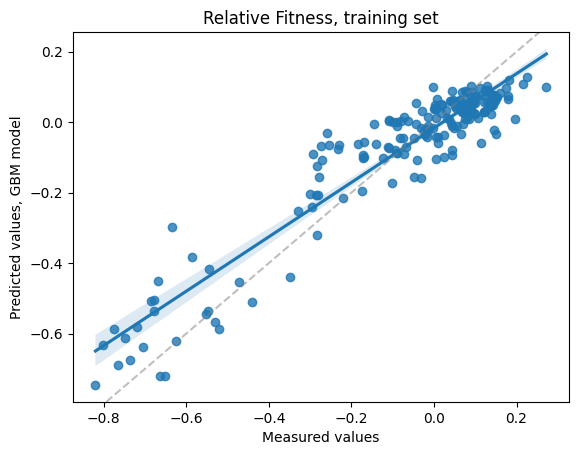

In [193]:
traindata_predicted = expression_to_rel_fitness(
    tfoesumm_df.loc[:, shared_tfa_fitness_strains] # match the strains we have fitness data on (all of which were used for training, FYI!)
)

ax = sns.regplot(
    x=tfoefitness_df['RelFitness'],
    y=traindata_predicted)
ax.set_xlabel('Measured values')
ax.set_ylabel('Predicted values, GBM model')
ax.axline((0, 0), slope=1, alpha=0.5, color='grey', linestyle='--')
ax.set_title('Relative Fitness, training set');

In [234]:
# normalized_l2fc_expression_df: genes x samples
def expression_to_rel_fitness_elasticnet(normalized_l2fc_expression_df):
    tfa_df = l2fc_to_tfas(normalized_l2fc_expression_df, control_strengths_df)
    tfa_scaled = StandardScaler().fit_transform(tfa_df.to_numpy(dtype=np.float64).T)
    raw_rel_fitness = elasticnet_model.predict(tfa_scaled)
    # return (raw_rel_fitness - raw_rel_fitness.min()) / (raw_rel_fitness.max() - raw_rel_fitness.min())
    # return raw_rel_fitness / max(abs(raw_rel_fitness))
    return raw_rel_fitness

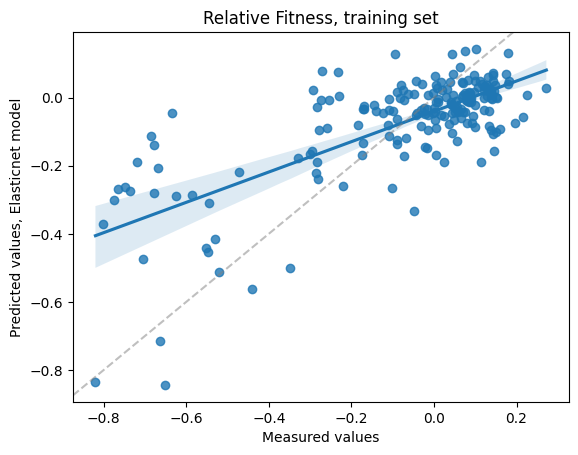

In [233]:
traindata_predicted_elasticnet = expression_to_rel_fitness_elasticnet(
    tfoesumm_df.loc[:, shared_tfa_fitness_strains] # match the strains we have fitness data on (all of which were used for training, FYI!)
)

ax = sns.regplot(
    x=tfoefitness_df['RelFitness'],
    y=traindata_predicted_elasticnet)
ax.set_xlabel('Measured values')
ax.set_ylabel('Predicted values, Elasticnet model')
ax.axline((0, 0), slope=1, alpha=0.5, color='grey', linestyle='--')
ax.set_title('Relative Fitness, training set');

# Test model on paired transcriptome/fitness data

## Test 1: Sherman lab CFZ, MXF, PA824 data

In [204]:
testdata1_df = pd.read_csv(
    'in/test_data/MtbExpressionData_ShermanLab_MXF_CFZ_PA824_Rformat.csv',
    index_col=0, header=0)
testdata1_df['Condition'] = testdata1_df['Drug'].str.cat(testdata1_df['Dose'], sep=' ')
print(testdata1_df.shape)
testdata1_df.head()

(32, 4036)


,Strain,Drug,Dose,Timept_h,Sub_batch,Rv0001,Rv0002,Rv0003,Rv0004,Rv0005,...,Rv3916c,Rv3917c,Rv3918c,Rv3919c,Rv3920c,Rv3921c,Rv3922c,Rv3923c,Rv3924c,Condition
SampleID,,,,,,,,,,,,,,,,,,,,,
H37Rv_0_02uM_MOX_T16_R2_S11_R1,H37Rv,MXF,0.02uM,16,1,228.23,383.32,276.58,244.36,647.21,...,191.09,222.20,102.38,259.74,991.64,776.43,1285.21,1677.11,1743.69,MXF 0.02uM
H37Rv_0_02uM_MOX_T16_R3_S12_R1,H37Rv,MXF,0.02uM,16,1,240.07,380.52,266.79,231.70,626.76,...,174.87,208.66,104.03,259.92,992.69,758.78,1243.03,1631.01,1767.85,MXF 0.02uM
H37Rv__005uM_MOX_T16_R1_S7_R1,H37Rv,MXF,0.005uM,16,1,236.61,405.66,267.74,234.70,883.45,...,203.51,255.73,126.88,267.89,916.11,788.58,1409.92,1756.34,1867.93,MXF 0.005uM
H37Rv__005uM_MOX_T16_R2_S8_R1,H37Rv,MXF,0.005uM,16,1,229.37,366.22,304.09,245.70,694.33,...,195.20,220.51,105.41,272.05,1072.84,830.09,1484.63,1762.45,1740.66,MXF 0.005uM
H37Rv__005uM_MOX_T16_R3_S9_R1,H37Rv,MXF,0.005uM,16,1,241.98,381.28,285.46,248.13,710.37,...,194.57,232.65,111.26,275.64,1041.33,847.37,1490.77,1791.64,1926.89,MXF 0.005uM


We have raw counts here. So we'll need to run pysnail, and convert to log2 fold-change.

### Prep data

In [209]:
# output data in proper format to run pysnail on, using docker container atm
testdata1_df.loc[:, 'Rv0001':'Rv3924c'].transpose().to_csv(
    'in/test_data/MtbExpressionData_ShermanLab_MXF_CFZ_PA824_pysnailprepformat.csv',
    sep='\t', index=True, header=True)
testdata1_df.loc[:, 'Rv0001':'Rv3924c'].to_csv(
    'in/test_data/MtbExpressionData_ShermanLab_MXF_CFZ_PA824_pysnailprepformat2.csv',
    sep='\t', index=True, header=True)
testdata1_df['Condition'].to_csv(
    'in/test_data/MtbExpressionData_ShermanLab_MXF_CFZ_PA824_pysnailgroupformat.csv',
    sep='\t', index=True, header=False)

```
docker run -it \
    --rm \
    --volume in/test_data:/root/mount \
    ethanbustadscri/pysnail:1.0 \
        /root/mount/MtbExpressionData_ShermanLab_MXF_CFZ_PA824_pysnailprepformat.csv \
            --groups /root/mount/MtbExpressionData_ShermanLab_MXF_CFZ_PA824_pysnailgroupformat.csv \
            --method 'auto' \
            --cutoff 0.15 \
            --outdir /root/mount

mv in/test_data/xprs_norm.tsv in/test_data/MtbExpressionData_ShermanLab_MXF_CFZ_PA824_pysnail.csv
```

In [213]:
testdata1_norm_df = pd.read_csv(
    'in/test_data/MtbExpressionData_ShermanLab_MXF_CFZ_PA824_pysnail.csv',
    sep='\t', index_col=0, header=0).T
print(testdata1_norm_df.shape)
testdata1_norm_df.head()

(32, 4030)


,Rv0001,Rv0002,Rv0003,Rv0004,Rv0005,Rv0006,Rv0007,Rv0008c,Rv0009,Rv0010c,...,Rv3915,Rv3916c,Rv3917c,Rv3918c,Rv3919c,Rv3920c,Rv3921c,Rv3922c,Rv3923c,Rv3924c
H37Rv_0_02uM_MOX_T16_R2_S11_R1,224.55,379.93,272.05,240.67,637.14,998.02,529.10,61.74,1284.97,776.11,...,402.45,187.01,218.72,100.35,255.25,992.84,781.36,1305.88,1713.64,1831.87
H37Rv_0_02uM_MOX_T16_R3_S12_R1,236.00,379.44,263.30,227.34,622.09,999.76,553.12,66.85,1273.44,788.88,...,425.22,169.70,204.70,101.28,255.66,1006.99,756.19,1245.82,1693.85,1822.00
H37Rv__005uM_MOX_T16_R1_S7_R1,233.17,404.20,265.91,231.09,877.26,990.76,505.38,55.52,1314.93,791.83,...,453.06,202.32,253.45,126.27,266.05,908.47,779.65,1408.28,1781.75,1863.48
H37Rv__005uM_MOX_T16_R2_S8_R1,226.62,363.54,296.53,241.53,704.10,1038.12,541.10,56.82,1240.00,789.97,...,380.67,190.33,215.97,103.95,267.85,1096.81,833.63,1533.45,1855.22,1802.53
H37Rv__005uM_MOX_T16_R3_S9_R1,238.02,377.30,280.11,244.02,701.55,1009.53,530.50,56.39,1337.99,819.80,...,411.74,189.84,227.76,109.10,269.84,1034.64,846.21,1501.89,1855.22,2004.07


#### `norm_to_l2fc()`

In [220]:
# norm_expression_df: pd.DataFrame of quantile normalized expression data, (samples x genes)
# control_idxs: boolean pd.Series indicating which samples represent the control samples, (samples,)
def norm_to_l2fc(norm_expression_df, control_idxs):
    return norm_expression_df[~control_idxs].div(
        norm_expression_df[control_idxs].mean(axis=0) # mean for each column/gene
    ).map(np.log2)

In [223]:
testdata1_control_idxs = testdata1_df['Drug'].eq('Untreated') & testdata1_df['Timept_h'].eq(16)
testdata1_norml2fc_df = norm_to_l2fc(
    testdata1_norm_df,
    testdata1_control_idxs
)

print(testdata1_norml2fc_df.shape)
testdata1_norml2fc_df.head()

(29, 4030)


,Rv0001,Rv0002,Rv0003,Rv0004,Rv0005,Rv0006,Rv0007,Rv0008c,Rv0009,Rv0010c,...,Rv3915,Rv3916c,Rv3917c,Rv3918c,Rv3919c,Rv3920c,Rv3921c,Rv3922c,Rv3923c,Rv3924c
H37Rv_0_02uM_MOX_T16_R2_S11_R1,-0.16,-9.78e-02,-6.94e-03,0.12,-0.24,0.03,0.20,0.25,-0.25,-8.67e-02,...,-0.14,-2.68e-02,-0.02,-1.21e-02,0.19,1.18e-01,0.02,-2.28e-01,-0.31,-0.45
H37Rv_0_02uM_MOX_T16_R3_S12_R1,-0.09,-9.96e-02,-5.41e-02,0.03,-0.28,0.03,0.26,0.37,-0.26,-6.31e-02,...,-0.06,-1.67e-01,-0.12,1.18e-03,0.20,1.39e-01,-0.03,-2.96e-01,-0.32,-0.46
H37Rv__005uM_MOX_T16_R1_S7_R1,-0.10,-8.44e-03,-3.99e-02,0.06,0.22,0.02,0.13,0.10,-0.22,-5.77e-02,...,0.03,8.67e-02,0.19,3.19e-01,0.25,-9.90e-03,0.01,-1.19e-01,-0.25,-0.43
H37Rv__005uM_MOX_T16_R2_S8_R1,-0.15,-1.61e-01,1.17e-01,0.12,-0.10,0.09,0.23,0.13,-0.30,-6.11e-02,...,-0.22,-1.40e-03,-0.04,3.88e-02,0.26,2.62e-01,0.11,3.50e-03,-0.19,-0.48
H37Rv__005uM_MOX_T16_R3_S9_R1,-0.08,-1.08e-01,3.52e-02,0.14,-0.10,0.05,0.20,0.12,-0.19,-7.67e-03,...,-0.11,-5.11e-03,0.04,1.09e-01,0.27,1.78e-01,0.13,-2.65e-02,-0.19,-0.32


### Make prediction

In [264]:
testdata1_results_df = testdata1_df.loc[:, 'Strain':'Timept_h'].copy()

testdata1_results_df['Condition'] = testdata1_results_df['Drug'].str.cat(testdata1_results_df['Dose'], sep=' ')
testdata1_results_df.loc[~testdata1_control_idxs, 'PredFitness'] = expression_to_rel_fitness(testdata1_norml2fc_df.T) # takes (genes x samples)

print(testdata1_results_df.shape)
testdata1_results_df.head()

(32, 6)


,Strain,Drug,Dose,Timept_h,Condition,PredFitness
SampleID,,,,,,
H37Rv_0_02uM_MOX_T16_R2_S11_R1,H37Rv,MXF,0.02uM,16,MXF 0.02uM,9.16e-02
H37Rv_0_02uM_MOX_T16_R3_S12_R1,H37Rv,MXF,0.02uM,16,MXF 0.02uM,9.16e-02
H37Rv__005uM_MOX_T16_R1_S7_R1,H37Rv,MXF,0.005uM,16,MXF 0.005uM,-7.92e-03
H37Rv__005uM_MOX_T16_R2_S8_R1,H37Rv,MXF,0.005uM,16,MXF 0.005uM,6.31e-02
H37Rv__005uM_MOX_T16_R3_S9_R1,H37Rv,MXF,0.005uM,16,MXF 0.005uM,6.31e-02


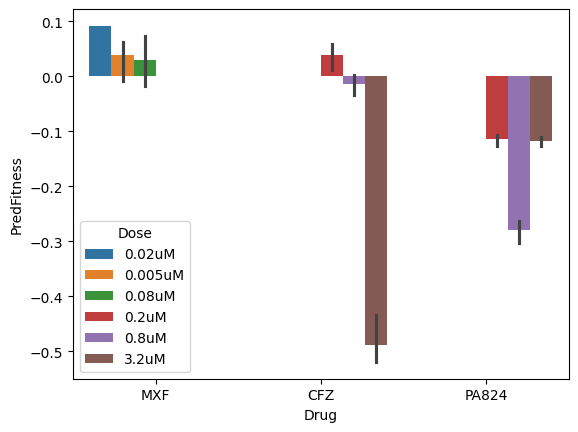

In [265]:
ax = sns.barplot(
    data=testdata1_results_df[testdata1_results_df['Timept_h'].eq(16)].dropna(), x='Drug', y='PredFitness',
    hue='Dose')

Overall, not a great prediction. Thoughts:
- CFZ does look good. Other drugs don't look very reasonable.
- This is based on RNA-seq data, whereas the model was trained on microarray data. This might be more significant than we'd hoped?
- This really isn't the best test set -- the conditions have been treated with varying levels of drug, but it wasn't meant as a differential survival experiment. It's possible the model outputs are an accurate picture of how the bug was doing at the time?
- Let's try a better test set. (I just chose this one because it was on hand.)

## Test 2: 2017 hypoxia dataset

### Read in dataset

In [242]:
testdata2_df = pd.read_excel(
    'in/test_data/CORR.TFI.RNAseq.10.4.17 1.csv.gz',
    index_col=0, usecols='A,C:BD', skiprows=6, nrows=4030)
print(testdata2_df.shape)
testdata2_df.head()

(4030, 54)


,EmptyPlasmid_D0_H5_R1,EmptyPlasmid_D0_H6_R2,EmptyPlasmid_D0_H7_R3,EmptyPlasmid_D0_TC6_R1,EmptyPlasmid_D2_H5_R1,EmptyPlasmid_D2_H6_R2,EmptyPlasmid_D2_H7_R3,EmptyPlasmid_D2_TC6_R1,EmptyPlasmid_D4_H5_R1,EmptyPlasmid_D4_H6_R2,...,Rv_D7_TC4_R2,Rv_D7_TC4_R2b,Rv_D7_TC4_R3,Rv_D7_TC4_R3b,Rv_D12_TC4_R1,Rv_D12_TC4_R1b,Rv_D12_TC4_R2,Rv_D12_TC4_R2b,Rv_D12_TC4_R3,Rv_D12_TC4_R3b
GENE_ID,,,,,,,,,,,,,,,,,,,,,
Rv0001,334.46,292.73,315.23,471.73,42.43,28.23,44.90,28.27,38.34,26.67,...,104.80,94.69,126.12,82.32,59.18,13.93,31.14,21.47,47.13,6.48
Rv0002,181.66,215.37,251.79,253.43,28.17,21.65,45.78,17.12,27.08,15.10,...,67.13,45.34,74.83,41.93,32.79,11.09,15.14,16.07,39.76,3.08
Rv0003,147.73,141.89,139.88,124.37,22.55,24.34,28.83,15.08,21.02,15.46,...,22.35,21.05,37.22,16.60,55.70,14.06,23.07,13.51,34.95,6.48
Rv0004,172.42,162.96,165.35,113.72,38.08,37.80,57.45,26.42,58.71,25.24,...,53.77,43.60,36.40,37.27,47.70,21.61,29.70,16.43,44.70,16.25
Rv0005,1630.58,987.03,1087.43,1193.93,400.57,218.15,515.17,169.10,483.83,274.53,...,457.41,726.59,510.36,782.15,61.74,33.63,37.14,96.91,60.37,46.81


In [248]:
testdata2_meta_df = pd.read_excel(
    'in/test_data/CORR.TFI.RNAseq.10.4.17 1.xlsx',
    sheet_name='All.MTb.GeneData', header=None, index_col=0, usecols='A,C:BD', nrows=5)
testdata2_meta_df.columns = testdata2_df.columns
testdata2_meta_df = testdata2_meta_df.T
print(testdata2_meta_df.shape)
testdata2_meta_df.head()

(54, 5)


,Strain,Day,TC,Rep,StrainDay
EmptyPlasmid_D0_H5_R1,EmptyPlasmid,0,H5,R1,EmptyPlasmidD0
EmptyPlasmid_D0_H6_R2,EmptyPlasmid,0,H6,R2,EmptyPlasmidD0
EmptyPlasmid_D0_H7_R3,EmptyPlasmid,0,H7,R3,EmptyPlasmidD0
EmptyPlasmid_D0_TC6_R1,EmptyPlasmid,0,TC6,R1,EmptyPlasmidD0
EmptyPlasmid_D2_H5_R1,EmptyPlasmid,2,H5,R1,EmptyPlasmidD2


### PySNAIL normalize

In [250]:
os.makedirs('generated', exist_ok=True)  
testdata2_df.to_csv(
    'generated/CORR.TFI.RNAseq.10.4.17_pysnailprepformat.csv',
    sep='\t', index=True, header=True)
testdata2_meta_df['StrainDay'].to_csv(
    'generated/CORR.TFI.RNAseq.10.4.17_pysnailgroupformat.csv',
    sep='\t', index=True, header=False)

```
docker run -it \
    --rm \
    --volume generated:/root/mount \
    ethanbustadscri/pysnail:1.0 \
        /root/mount/CORR.TFI.RNAseq.10.4.17_pysnailprepformat.csv \
            --groups /root/mount/CORR.TFI.RNAseq.10.4.17_pysnailgroupformat.csv \
            --method 'auto' \
            --cutoff 0.15 \
            --outdir /root/mount

mv generated/xprs_norm.tsv generated/CORR.TFI.RNAseq.10.4.17_pysnail.csv
```

In [281]:
testdata2_norm_df = pd.read_csv(
    'generated/CORR.TFI.RNAseq.10.4.17_pysnail.csv',
    sep='\t', index_col=0, header=0).T
print(testdata2_norm_df.shape)
testdata2_norm_df.head()

(54, 4030)


,Rv0001,Rv0002,Rv0003,Rv0004,Rv0005,Rv0006,Rv0007,Rv0008c,Rv0009,Rv0010c,...,Rv3915,Rv3916c,Rv3917c,Rv3918c,Rv3919c,Rv3920c,Rv3921c,Rv3922c,Rv3923c,Rv3924c
EmptyPlasmid_D0_H5_R1,325.56,176.83,144.25,168.53,1758.42,1026.75,480.09,56.36,714.04,705.60,...,362.76,385.71,567.76,425.23,689.45,1768.35,1111.18,1311.18,1189.30,706.95
EmptyPlasmid_D0_H6_R2,276.92,201.17,133.42,153.08,1002.26,766.24,457.47,81.07,1197.04,679.84,...,391.32,227.18,385.95,314.43,540.93,1579.20,1201.52,1119.11,1233.36,1392.40
EmptyPlasmid_D0_H7_R3,298.80,237.05,129.50,152.53,1094.05,818.08,454.97,70.20,1405.24,719.50,...,393.62,242.46,295.74,244.23,370.60,1233.36,949.01,1127.94,1374.52,1427.83
EmptyPlasmid_D0_TC6_R1,488.04,287.84,144.98,133.63,1119.11,774.35,372.74,90.77,910.87,553.31,...,508.63,350.44,553.56,425.23,559.26,1251.88,1073.75,973.22,976.22,1040.80
EmptyPlasmid_D2_H5_R1,51.02,35.54,28.87,46.47,422.63,151.60,69.66,42.55,511.75,288.60,...,710.37,2485.96,262.62,95.83,89.60,82.16,33.43,32.94,60.82,110.87


### Convert to l2fc

In [257]:
testdata2_norml2fc_df = pd.concat((
    norm_to_l2fc(
        testdata2_norm_df[testdata2_meta_df['Strain'].eq('EmptyPlasmid')],
        testdata2_meta_df['Strain'].eq('EmptyPlasmid') & testdata2_meta_df['Day'].eq(0)
    ),
    norm_to_l2fc(
        testdata2_norm_df[testdata2_meta_df['Strain'].eq('Rv')],
        testdata2_meta_df['Strain'].eq('Rv') & testdata2_meta_df['Day'].eq(0)
    ),
))

print(testdata2_norml2fc_df.shape)
testdata2_norml2fc_df.head()

C:\Users\Ethan\AppData\Local\Temp\ipykernel_41048\3917715750.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return norm_expression_df[~control_idxs].div(
C:\Users\Ethan\AppData\Local\Temp\ipykernel_41048\3917715750.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  norm_expression_df[control_idxs].mean(axis=0) # mean for each column/gene
C:\Users\Ethan\AppData\Local\Temp\ipykernel_41048\3917715750.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return norm_expression_df[~control_idxs].div(
C:\Users\Ethan\AppData\Local\Temp\ipykernel_41048\3917715750.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  norm_expression_df[control_idxs].mean(axis=0) # mean for each column/gene


(47, 4030)


,Rv0001,Rv0002,Rv0003,Rv0004,Rv0005,Rv0006,Rv0007,Rv0008c,Rv0009,Rv0010c,...,Rv3915,Rv3916c,Rv3917c,Rv3918c,Rv3919c,Rv3920c,Rv3921c,Rv3922c,Rv3923c,Rv3924c
EmptyPlasmid_D2_H5_R1,-2.77,-2.67,-2.26,-1.71,-1.56,-2.48,-2.66,-0.81,-1.05,-1.20,...,0.78,3.04,-0.78,-1.88,-2.59,-4.15,-5.02,-5.10,-4.29,-3.36
EmptyPlasmid_D2_H6_R2,-3.56,-3.30,-2.43,-1.95,-2.42,-3.69,-2.61,-0.63,-0.51,-1.93,...,0.97,3.44,0.36,-1.52,-2.38,-3.94,-5.28,-5.53,-3.91,-2.38
EmptyPlasmid_D2_H7_R3,-3.18,-2.53,-2.47,-1.65,-1.41,-2.87,-2.12,-0.69,0.34,-0.99,...,0.82,3.15,-0.80,-1.85,-2.42,-4.19,-4.82,-4.25,-3.16,-2.48
EmptyPlasmid_D2_TC6_R1,-3.47,-3.55,-2.99,-2.36,-2.81,-3.52,-2.15,-0.39,-1.78,-2.84,...,0.72,2.98,-0.08,-1.75,-2.48,-4.01,-5.39,-5.85,-4.84,-3.32
EmptyPlasmid_D4_H5_R1,-2.95,-2.79,-2.42,-1.19,-1.27,-1.93,-1.87,-0.41,-1.41,-1.17,...,0.80,2.15,-1.33,-1.78,-2.77,-4.26,-5.17,-5.30,-4.75,-4.38


### Predict fitness

In [258]:
testdata2_results_df = testdata2_meta_df.copy()

testdata2_results_df.loc[testdata2_meta_df['Day'].ne(0), 'PredFitness'] = expression_to_rel_fitness(testdata2_norml2fc_df.T) # takes (genes x samples)

print(testdata2_results_df.shape)
testdata2_results_df.head()

(54, 6)


,Strain,Day,TC,Rep,StrainDay,PredFitness
EmptyPlasmid_D0_H5_R1,EmptyPlasmid,0,H5,R1,EmptyPlasmidD0,NaN
EmptyPlasmid_D0_H6_R2,EmptyPlasmid,0,H6,R2,EmptyPlasmidD0,NaN
EmptyPlasmid_D0_H7_R3,EmptyPlasmid,0,H7,R3,EmptyPlasmidD0,NaN
EmptyPlasmid_D0_TC6_R1,EmptyPlasmid,0,TC6,R1,EmptyPlasmidD0,NaN
EmptyPlasmid_D2_H5_R1,EmptyPlasmid,2,H5,R1,EmptyPlasmidD2,-0.23


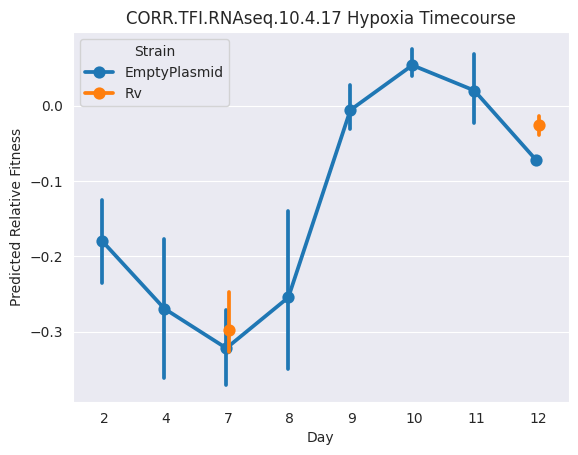

In [295]:
with sns.axes_style(style='darkgrid'):
    ax = sns.pointplot(
        data=testdata2_results_df.dropna(),
        x='Day', y='PredFitness',
        hue='Strain', dodge=True,
    )
    ax.set_ylabel('Predicted Relative Fitness')
    ax.set_title('CORR.TFI.RNAseq.10.4.17 Hypoxia Timecourse')

In [263]:
testdata2_results_df.to_csv('CORR.TFI.RNAseq.10.4.17_results.csv', sep=',', header=True, index=True)

So good! Days 0-7 represent hypoxic conditions, so lower growth/fitness expected. Days 8+ represent re-aeration, so increased growth/fitness is expected, with potentially a little lag!

#### Look at important features?

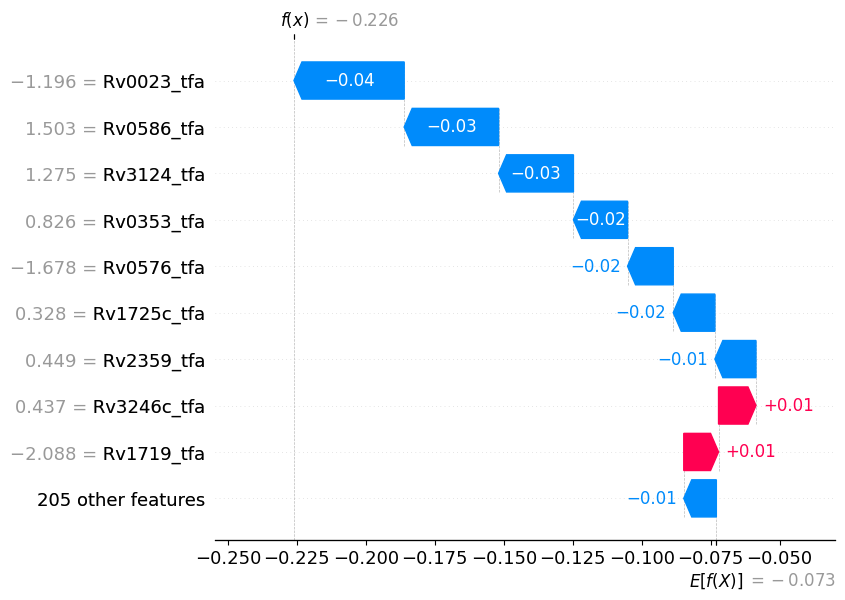

In [339]:
testdata2_rel_fitness, shap_values = expression_to_rel_fitness(testdata2_norml2fc_df.T, include_explainer=True) # takes (genes x samples)

shap.plots.waterfall(shap_values[0])

In [340]:
shap.initjs()
shap.plots.force(shap_values)

In [378]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

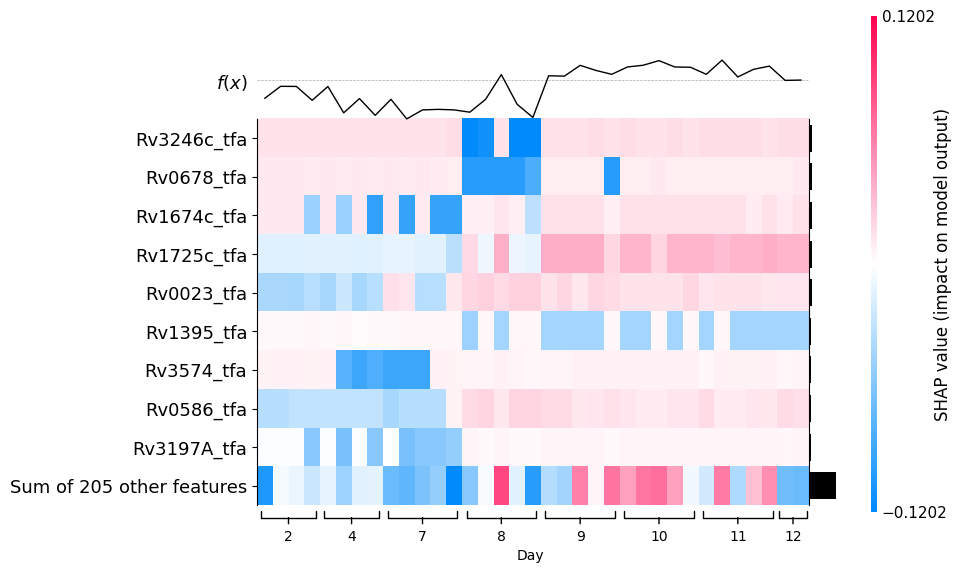

In [400]:
testdata2_results_df2 = testdata2_results_df.dropna()

fig = plt.figure(figsize=(6, 4), dpi=100)
ax = shap.plots.heatmap(
    shap_values[testdata2_results_df2['Strain'].eq('EmptyPlasmid').to_numpy()],
    instance_order=np.array(range(testdata2_results_df2['Strain'].eq('EmptyPlasmid').sum())),
    show=False,
)

ax.set_xlabel('')
ax.set_xticks([])

emptyplasmid_days = testdata2_results_df2.loc[testdata2_results_df2['Strain'].eq('EmptyPlasmid'), 'Day']

colormap = dict(zip(
    [str(day) for day in sorted(emptyplasmid_days.unique())],
    sns.color_palette('Set2', n_colors=len(emptyplasmid_days.unique()))
))

# divider = make_axes_locatable(ax)
# day_ax = divider.append_axes('bottom', '10%', pad=0.06)
# day_ax.invert_yaxis()
# day_ax.set_ylabel('')
# day_ax.set_yticks([])
# day_ax.bar(
#     x=range(len(emptyplasmid_days)), height=np.ones(len(emptyplasmid_days)), 
#     width=np.ones(len(emptyplasmid_days)), color=emptyplasmid_days.map(str).map(colormap)
# )
# # for i, day in enumerate(emptyplasmid_days):
# #     day_ax.text(x=0.5+i, y=0.5, s=day)
# count_so_far = 0
# total_count = len(emptyplasmid_days)
# for day, count in emptyplasmid_days.value_counts().sort_index().items():
#     day_ax.text(x=count_so_far + count/2 - 0.5, y=2, s=str(day), horizontalalignment='center')
#     count_so_far += count

# cmap = (mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan'])
#         .with_extremes(under='yellow', over='magenta'))
# cmap = sns.color_palette('Set2', n_colors=len(emptyplasmid_days.unique()), as_cmap=True)
# bounds = np.insert(np.cumsum(emptyplasmid_days.value_counts().sort_index()), 0, 0, axis=0)
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# fig.colorbar(
#     mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
#     cax=ax, orientation='horizontal',
#     # extend='both',
#     spacing='proportional',
#     label='Discrete intervals, some other units',
# )

count_so_far = 0
total_count = len(emptyplasmid_days)
for day, count in emptyplasmid_days.value_counts().sort_index().items():
    # day_ax.text(x=count_so_far + count/2 - 0.5, y=2, s=str(day), horizontalalignment='center')
    ax.annotate(
        str(day), xy=((count_so_far+count/2)/total_count, -0.02),
        xytext=((count_so_far+count/2)/total_count, -0.05), xycoords='axes fraction', 
        ha='center', va='top',
        arrowprops=dict(arrowstyle=f'-[, widthB={count/2}, lengthB=0.5', lw=1.0, color='k'))
    count_so_far += count

ax.text(x=0.45, y=0.1, s='Day', transform=fig.transFigure);

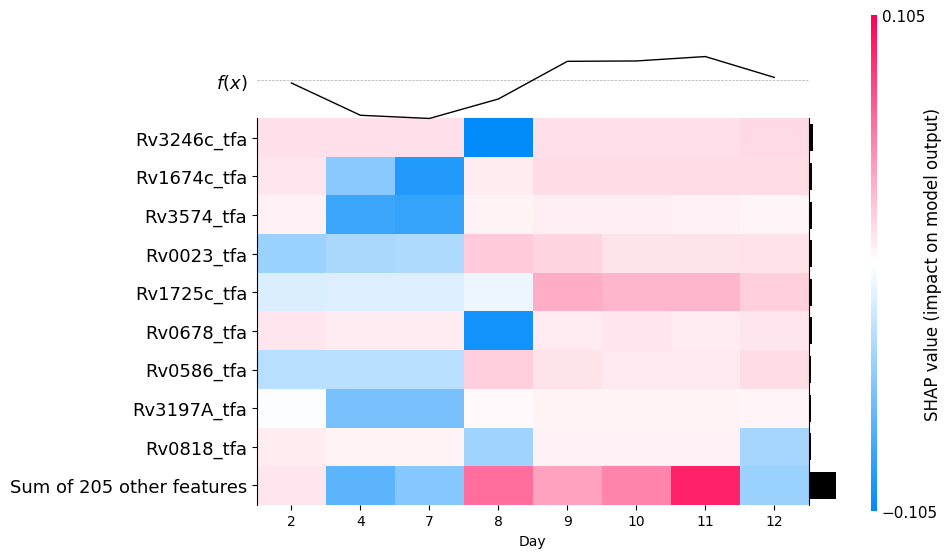

In [423]:
# testdata2_rel_fitness, shap_values = expression_to_rel_fitness(testdata2_norml2fc_df.T, include_explainer=True) # takes (genes x samples)
testdata2grp_norml2fc_df = testdata2_norml2fc_df.copy()

testdata2grp_norml2fc_df['Day'] = testdata2_meta_df['Day']
testdata2grp_norml2fc_df['Strain'] = testdata2_meta_df['Strain']

testdata2grp_norml2fc_df = testdata2grp_norml2fc_df[
    testdata2grp_norml2fc_df['Strain'].eq('EmptyPlasmid') # just get EmptyPlasmid rows -- exclude Rv for now
].drop(
    columns='Strain' # don't need this column any more, now that we've filtered on it
).groupby(
    'Day'
).agg(
    np.mean # should really be geometric (scipy.stats.gmean), but.. negative values :/
)


testdata2grp_tfa_df = l2fc_to_tfas(testdata2grp_norml2fc_df.T, control_strengths_df)
testdata2grp_tfa_scaled = StandardScaler().fit_transform(testdata2grp_tfa_df.to_numpy(dtype=np.float64).T)
testdata2grp_tfa_rel_fitness = lgbm_model2.predict(testdata2grp_tfa_scaled)
testdata2grp_shap_explainer = shap.Explainer(
    lgbm_model2, feature_names=testdata2grp_tfa_df.index.to_series().to_numpy())
testdata2grp_shap_values = testdata2grp_shap_explainer(testdata2grp_tfa_scaled)

testdata2grp_results_df = testdata2_meta_df.loc[
    testdata2_meta_df['Strain'].eq('EmptyPlasmid') & testdata2_meta_df['Day'].ne(0),
    ['Strain', 'Day', 'StrainDay']
].groupby(
    'StrainDay'
).max().sort_values('Day')

testdata2grp_results_df['PredFitness'] = testdata2grp_tfa_rel_fitness

fig = plt.figure(figsize=(6, 4), dpi=100)
ax = shap.plots.heatmap(
    testdata2grp_shap_values,
    instance_order=np.array(range(len(testdata2grp_shap_values))),
    show=False,
)

ax.set_xlabel('Day')
ax.set_xticks(range(len(testdata2grp_results_df['Day'])), testdata2grp_results_df['Day']);

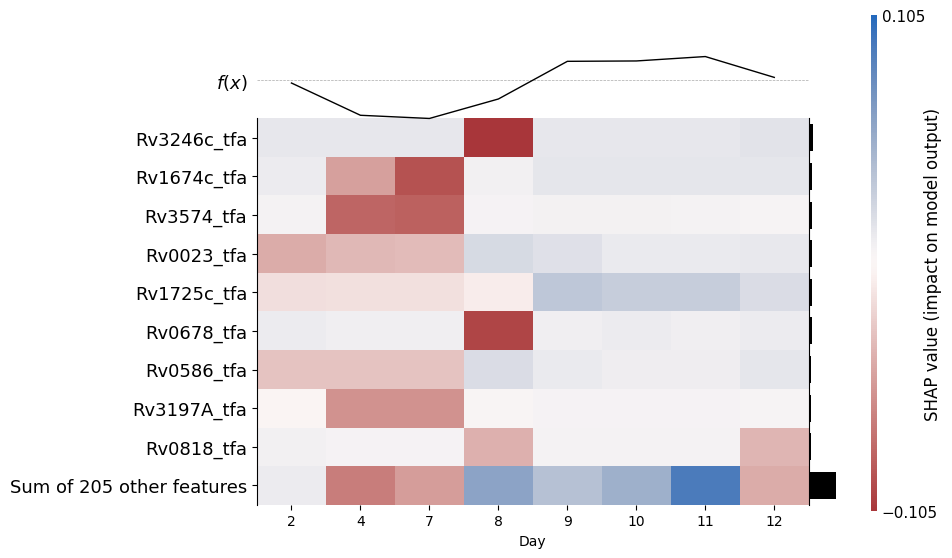

In [424]:
fig = plt.figure(figsize=(6, 4), dpi=100)
ax = shap.plots.heatmap(
    testdata2grp_shap_values,
    instance_order=np.array(range(len(testdata2grp_shap_values))),
    cmap=sns.color_palette('vlag_r', as_cmap=True),
    show=False,
)

ax.set_xlabel('Day')
ax.set_xticks(range(len(testdata2grp_results_df['Day'])), testdata2grp_results_df['Day']);

In [425]:
testdata2grp_tfa_rel_fitness1 = lgbm_model2.predict(testdata2grp_tfa_scaled)
testdata2grp_tfa_rel_fitness2 = lgbm_model2.predict(testdata2grp_tfa_scaled, pred_contrib=True)

In [426]:
testdata2grp_tfa_rel_fitness1

array([-0.09983172, -0.3726308 , -0.39956537, -0.23488522,  0.08358889,
        0.08669527,  0.12399323, -0.0523178 ])

In [427]:
testdata2grp_tfa_rel_fitness2

array([[-0.00669528,  0.        ,  0.        , ..., -0.0002152 ,
         0.        , -0.072939  ],
       [ 0.00068474,  0.        ,  0.        , ..., -0.00067397,
         0.        , -0.072939  ],
       [ 0.00068474,  0.        ,  0.        , ..., -0.00067397,
         0.        , -0.072939  ],
       ...,
       [ 0.0004625 ,  0.        ,  0.        , ..., -0.0002152 ,
         0.        , -0.072939  ],
       [ 0.0004625 ,  0.        ,  0.        , ...,  0.00056812,
         0.        , -0.072939  ],
       [ 0.0004625 ,  0.        ,  0.        , ...,  0.00056812,
         0.        , -0.072939  ]])

In [428]:
testdata2grp_tfa_rel_fitness2.shape

(8, 215)

In [435]:
mean_imp_days2to7 = testdata2grp_tfa_rel_fitness2[:3].mean(axis=0) # mean feature importance for days 2-7
mean_imp_days9toend = testdata2grp_tfa_rel_fitness2[4:].mean(axis=0) # mean feature importance for days 9-12

mean_imp_days2to7[:-1] - mean_imp_days9toend[:-1] # chop one off the end because the last column is the expected value

array([-2.23776847e-03,  0.00000000e+00,  0.00000000e+00, -4.99151912e-02,
        4.21267940e-03, -1.14073325e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.54166091e-04,  2.62251529e-03,  0.00000000e+00,
        0.00000000e+00, -9.76767478e-05,  2.63907712e-03, -4.19906861e-03,
        0.00000000e+00, -3.62972663e-03,  4.39970192e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.12138570e-05,  0.00000000e+00,  0.00000000e+00, -4.24557497e-03,
        0.00000000e+00, -7.66788453e-04, -1.62285159e-03, -2.24257606e-03,
       -2.16214166e-02, -1.31601915e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.54832785e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.18783569e-04,
       -4.00991549e-02,  0.00000000e+00,  0.00000000e+00,  2.82794171e-03,
       -2.02646102e-03,  0.00000000e+00,  0.00000000e+00, -2.60851355e-04,
        0.00000000e+00,  

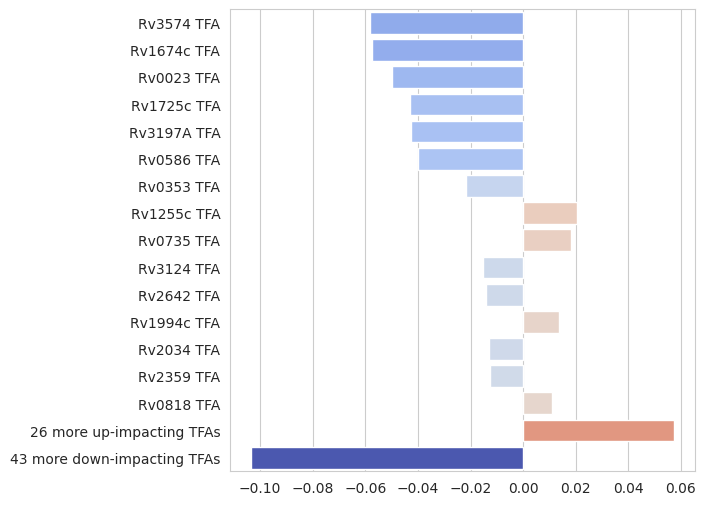

In [461]:
fig = plt.figure(figsize=(6, 6))

hyp_reaer_diff = mean_imp_days2to7[:-1] - mean_imp_days9toend[:-1]

# sort values and labels by absolute difference, descending

hyp_reaer_sort_idxs = np.argsort(1 - abs(hyp_reaer_diff), kind='stable')

hyp_reaer_diff = hyp_reaer_diff[hyp_reaer_sort_idxs]
hyp_reaer_labels = testdata2grp_tfa_df.index.to_series().to_numpy()[hyp_reaer_sort_idxs]

# pick out the interesting sets of indices

interest_threshold = 0.01

small_ups = (hyp_reaer_diff > 0) & (hyp_reaer_diff < interest_threshold)
small_downs = (hyp_reaer_diff < 0) & (hyp_reaer_diff > -interest_threshold)
large_impacts = abs(hyp_reaer_diff) >= interest_threshold

# assemble the values and rows that we want to plot

plottable_diffs = np.concatenate((
    hyp_reaer_diff[large_impacts],
    (
        hyp_reaer_diff[small_ups].sum(),
        hyp_reaer_diff[small_downs].sum()
    )
))
plottable_diff_labels = np.concatenate((
    [label.replace('_tfa', ' TFA') for label in hyp_reaer_labels[large_impacts]],
    (
        f'{small_ups.sum()} more up-impacting TFAs',
        f'{small_downs.sum()} more down-impacting TFAs'
    )
))

# and plot them

with sns.axes_style(style='whitegrid'):
    sns.barplot(
        x=plottable_diffs,
        y=plottable_diff_labels,
        hue=plottable_diffs,
        palette='coolwarm',
        hue_norm=mpl.colors.TwoSlopeNorm(vcenter=0, vmin=-max(abs(plottable_diffs)), vmax=max(abs(plottable_diffs))),
        legend=False,
    );

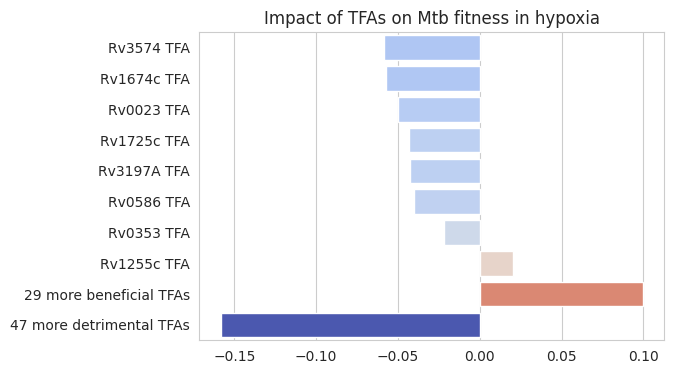

In [463]:
fig = plt.figure(figsize=(6, 4))

# pick out the interesting sets of indices

interest_threshold = 0.02

small_ups = (hyp_reaer_diff > 0) & (hyp_reaer_diff < interest_threshold)
small_downs = (hyp_reaer_diff < 0) & (hyp_reaer_diff > -interest_threshold)
large_impacts = abs(hyp_reaer_diff) >= interest_threshold

# assemble the values and rows that we want to plot

plottable_diffs = np.concatenate((
    hyp_reaer_diff[large_impacts],
    (
        hyp_reaer_diff[small_ups].sum(),
        hyp_reaer_diff[small_downs].sum()
    )
))
plottable_diff_labels = np.concatenate((
    [label.replace('_tfa', ' TFA') for label in hyp_reaer_labels[large_impacts]],
    (
        f'{small_ups.sum()} more beneficial TFAs',
        f'{small_downs.sum()} more detrimental TFAs'
    )
))

# and plot them

with sns.axes_style(style='whitegrid'):
    ax = sns.barplot(
        x=plottable_diffs,
        y=plottable_diff_labels,
        hue=plottable_diffs,
        palette='coolwarm',
        hue_norm=mpl.colors.TwoSlopeNorm(vcenter=0, vmin=-max(abs(plottable_diffs)), vmax=max(abs(plottable_diffs))),
        legend=False,
    )
    ax.set_title('Impact of TFAs on Mtb fitness in hypoxia')

In [464]:
print('Total beneficial impact:', hyp_reaer_diff[hyp_reaer_diff > 0].sum())
print('Total detrimental impact:', hyp_reaer_diff[hyp_reaer_diff < 0].sum())

Total beneficial impact: 0.1204559334075623
Total detrimental impact: -0.47162179590133174


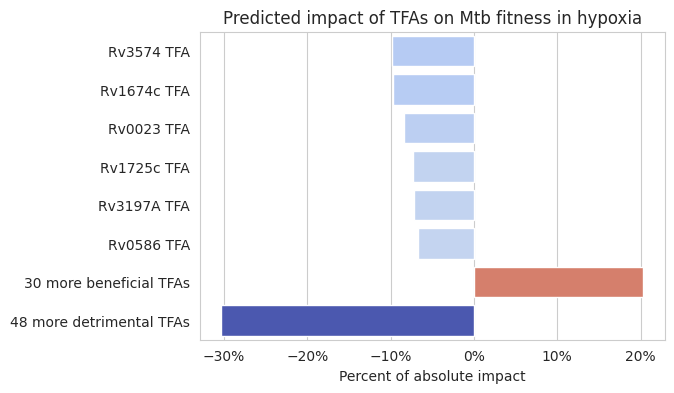

In [472]:
# PLOT IT IN TERMS OF PERCENT OF TOTAL EFFECT

fig = plt.figure(figsize=(6, 4))

# pick out the interesting sets of indices

total_benefit = hyp_reaer_diff[hyp_reaer_diff > 0].sum()
total_detriment = hyp_reaer_diff[hyp_reaer_diff < 0].sum()
total_effect = total_benefit + abs(total_detriment)

hyp_reaer_pct_diff = hyp_reaer_diff / total_effect

interest_threshold_pct = 0.05

small_ups = (hyp_reaer_diff > 0) & (hyp_reaer_pct_diff < interest_threshold_pct)
small_downs = (hyp_reaer_diff < 0) & (hyp_reaer_pct_diff > -interest_threshold_pct)
large_impacts = abs(hyp_reaer_pct_diff) >= interest_threshold_pct

# assemble the values and rows that we want to plot

plottable_diffs = np.concatenate((
    hyp_reaer_pct_diff[large_impacts],
    (
        hyp_reaer_pct_diff[small_ups].sum(),
        hyp_reaer_pct_diff[small_downs].sum()
    )
))
plottable_diff_labels = np.concatenate((
    [label.replace('_tfa', ' TFA') for label in hyp_reaer_labels[large_impacts]],
    (
        f'{small_ups.sum()} more beneficial TFAs',
        f'{small_downs.sum()} more detrimental TFAs'
    )
))

# and plot them

with sns.axes_style(style='whitegrid'):
    ax = sns.barplot(
        x=plottable_diffs,
        y=plottable_diff_labels,
        hue=plottable_diffs,
        palette='coolwarm', # TODO: discretize -- one blue, one red
        hue_norm=mpl.colors.TwoSlopeNorm(vcenter=0, vmin=-max(abs(plottable_diffs)), vmax=max(abs(plottable_diffs))),
        legend=False,
    )
    ax.set_title('Predicted impact of TFAs on Mtb fitness in hypoxia')
    ax.set_xlabel('Percent of absolute impact')
    ax.xaxis.set_major_formatter(PercentFormatter(1))

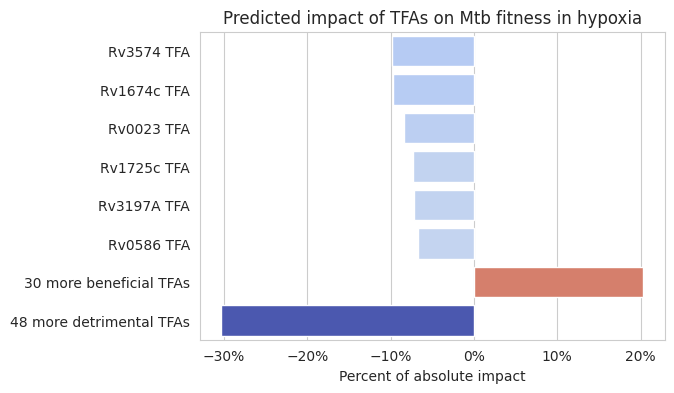

In [486]:
# PLOT IT IN TERMS OF PERCENT OF TOTAL EFFECT

fig = plt.figure(figsize=(6, 4))

# pick out the interesting sets of indices

total_benefit = hyp_reaer_diff[hyp_reaer_diff > 0].sum()
total_detriment = hyp_reaer_diff[hyp_reaer_diff < 0].sum()
total_effect = total_benefit + abs(total_detriment)

hyp_reaer_pct_diff = hyp_reaer_diff / total_effect

interest_threshold_pct = 0.05

small_ups = (hyp_reaer_diff > 0) & (hyp_reaer_pct_diff < interest_threshold_pct)
small_downs = (hyp_reaer_diff < 0) & (hyp_reaer_pct_diff > -interest_threshold_pct)
large_impacts = abs(hyp_reaer_pct_diff) >= interest_threshold_pct

# assemble the values and rows that we want to plot

plottable_diffs = np.concatenate((
    hyp_reaer_pct_diff[large_impacts],
    (
        hyp_reaer_pct_diff[small_ups].sum(),
        hyp_reaer_pct_diff[small_downs].sum()
    )
))
plottable_diff_labels = np.concatenate((
    [label.replace('_tfa', ' TFA') for label in hyp_reaer_labels[large_impacts]],
    (
        f'{small_ups.sum()} more beneficial TFAs',
        f'{small_downs.sum()} more detrimental TFAs'
    )
))

# and plot them

with sns.axes_style(style='whitegrid'):
    ax = sns.barplot(
        x=plottable_diffs,
        y=plottable_diff_labels,
        hue=plottable_diffs,
        palette='coolwarm', # TODO: discretize -- one blue, one red
        hue_norm=mpl.colors.TwoSlopeNorm(vcenter=0, vmin=-max(abs(plottable_diffs)), vmax=max(abs(plottable_diffs))),
        legend=False,
    )
    ax.set_title('Predicted impact of TFAs on Mtb fitness in hypoxia')
    ax.set_xlabel('Percent of absolute impact')
    ax.xaxis.set_major_formatter(PercentFormatter(1))

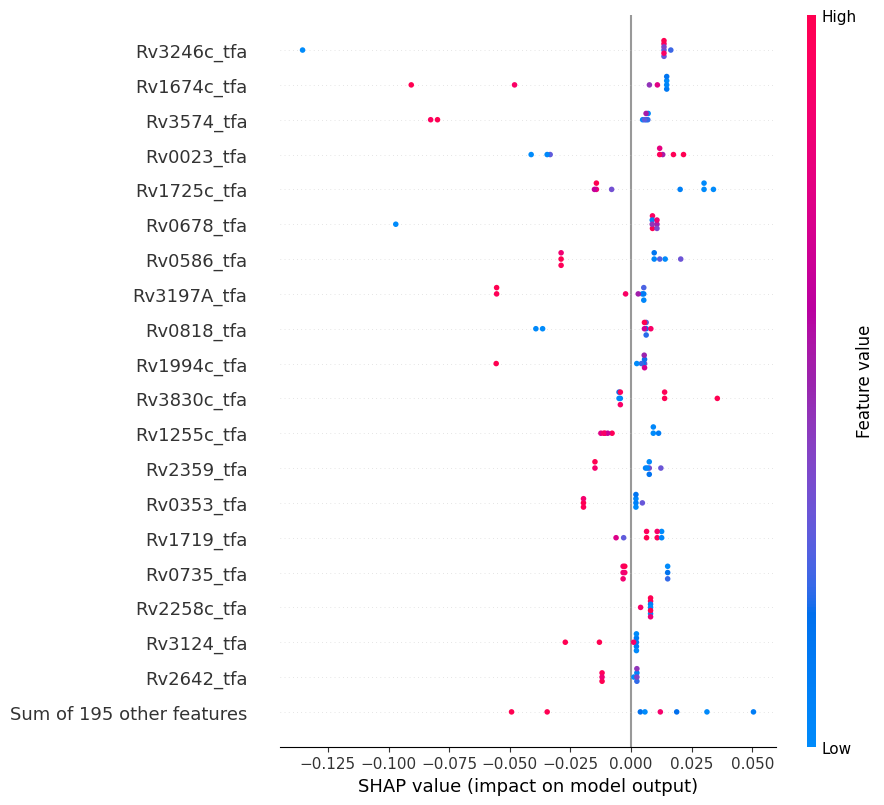

In [489]:
explainer = shap.TreeExplainer(lgbm_model2, feature_names=testdata2grp_tfa_df.index.to_series().to_numpy())
explanation = explainer(testdata2grp_tfa_scaled)
shap.plots.beeswarm(explanation, max_display=20)

In [502]:
def get_top_interactions(feature, sorted=True, sort_absolute=True):
    features = testdata2grp_tfa_df.index.to_series().to_numpy()
    idx = list(features).index(feature)
    shap_interaction_values = explainer.shap_interaction_values(testdata2grp_tfa_scaled)
    feature_interaction_values = shap_interaction_values[:, idx, :].mean(axis=0)
    if sorted:
        sortable = abs(feature_interaction_values) if sort_absolute else feature_interaction_values
        sort_idxs = list(reversed(np.argsort(sortable, kind='stable')))
        features = features[sort_idxs]
        feature_interaction_values = feature_interaction_values[sort_idxs]
    return pd.Series(feature_interaction_values, index=features)

In [504]:
get_top_interactions('Rv1674c_tfa').iloc[0:5]

Rv1674c_tfa   -8.10e-03
Rv2884_tfa     9.95e-04
Rv2745c_tfa   -6.97e-04
Rv0678_tfa    -4.52e-04
Rv2034_tfa     4.17e-04
dtype: float64

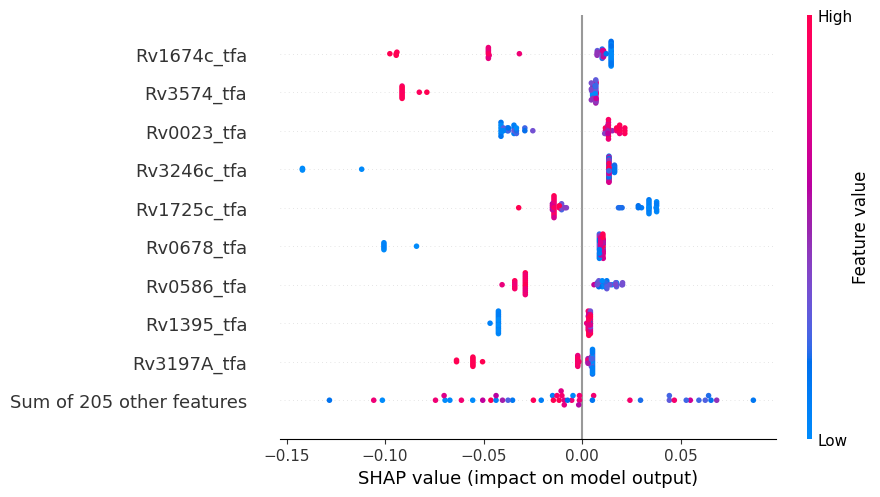

In [532]:
testdata2_rel_fitness, shap_values = expression_to_rel_fitness(testdata2_norml2fc_df.T, include_explainer=True) # takes (genes x samples)
# features = testdata2grp_tfa_df.index.to_series().to_numpy()
# desired_features = ['Rv1674c_tfa', 'Rv3574_tfa', 'Rv0023_tfa', 'Rv3246c_tfa', 'Rv1725c_tfa', 'Rv0678_tfa', 'Rv0586_tfa', 'Rv1395_tfa', 'Rv3197A_tfa']
# desired_idxs = np.in1d(features, desired_features)

# shap.plots.beeswarm(shap_values, s=(testdata2_rel_fitness + 0.8) * 10)
# shap.plots.beeswarm(shap_values[:, desired_idxs], s=(testdata2_rel_fitness + 0.8) * 10)
shap.plots.beeswarm(shap_values)

In [534]:
features = testdata2grp_tfa_df.index.to_series().to_numpy()
desired_features = ['Rv1674c_tfa', 'Rv3574_tfa', 'Rv0023_tfa', 'Rv3246c_tfa', 'Rv1725c_tfa', 'Rv0678_tfa', 'Rv0586_tfa', 'Rv1395_tfa', 'Rv3197A_tfa']
testdata2grp_tfa_df.loc[desired_features]

Day,2,4,7,8,9,10,11,12
Regulator,,,,,,,,
Rv1674c_tfa,2.21e-01,0.26,0.29,1.49e-01,7.24e-02,3.84e-02,5.24e-02,7.81e-02
Rv3574_tfa,7.90e-03,0.06,0.05,-1.77e-02,-2.44e-02,-4.66e-02,-4.51e-02,-4.36e-02
Rv0023_tfa,-1.21e-01,-0.12,-0.09,-4.46e-03,-7.49e-03,-1.02e-02,-3.04e-02,-5.99e-02
Rv3246c_tfa,6.44e-02,0.10,0.07,-1.51e-01,-6.48e-02,-4.20e-02,-5.88e-02,-7.67e-02
Rv1725c_tfa,6.14e-02,0.08,0.10,3.50e-02,3.09e-03,3.48e-03,2.91e-03,9.87e-03
Rv0678_tfa,1.40e-01,0.22,0.17,-2.43e-01,-1.91e-01,-6.14e-02,-2.80e-02,-5.13e-03
Rv0586_tfa,2.58e-01,0.27,0.22,5.77e-02,3.90e-02,-4.24e-04,-3.35e-02,-5.10e-02
Rv1395_tfa,4.40e-01,0.40,0.43,1.57e-01,3.62e-02,1.03e-02,8.66e-03,1.59e-02
Rv3197A_tfa,2.93e-01,0.31,0.33,1.51e-01,5.62e-02,4.10e-03,-2.41e-02,-3.95e-02


In [536]:
test_top_tfas_df = testdata2grp_tfa_df.loc[desired_features].copy()
# test_top_tfas_df.loc['fitness', :] = testdata2_rel_fitness
test_top_tfas_df

Day,2,4,7,8,9,10,11,12
Regulator,,,,,,,,
Rv1674c_tfa,2.21e-01,0.26,0.29,1.49e-01,7.24e-02,3.84e-02,5.24e-02,7.81e-02
Rv3574_tfa,7.90e-03,0.06,0.05,-1.77e-02,-2.44e-02,-4.66e-02,-4.51e-02,-4.36e-02
Rv0023_tfa,-1.21e-01,-0.12,-0.09,-4.46e-03,-7.49e-03,-1.02e-02,-3.04e-02,-5.99e-02
Rv3246c_tfa,6.44e-02,0.10,0.07,-1.51e-01,-6.48e-02,-4.20e-02,-5.88e-02,-7.67e-02
Rv1725c_tfa,6.14e-02,0.08,0.10,3.50e-02,3.09e-03,3.48e-03,2.91e-03,9.87e-03
Rv0678_tfa,1.40e-01,0.22,0.17,-2.43e-01,-1.91e-01,-6.14e-02,-2.80e-02,-5.13e-03
Rv0586_tfa,2.58e-01,0.27,0.22,5.77e-02,3.90e-02,-4.24e-04,-3.35e-02,-5.10e-02
Rv1395_tfa,4.40e-01,0.40,0.43,1.57e-01,3.62e-02,1.03e-02,8.66e-03,1.59e-02
Rv3197A_tfa,2.93e-01,0.31,0.33,1.51e-01,5.62e-02,4.10e-03,-2.41e-02,-3.95e-02


In [538]:
testdata2grp_tfa_rel_fitness1

array([-0.09983172, -0.3726308 , -0.39956537, -0.23488522,  0.08358889,
        0.08669527,  0.12399323, -0.0523178 ])

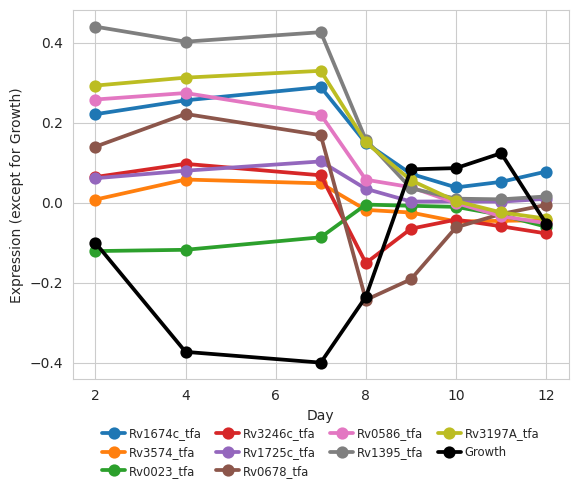

In [548]:
with sns.axes_style(style='whitegrid'):
    ax = sns.pointplot(
        data=test_top_tfas_df.reset_index().melt(id_vars='Regulator', value_name='Expression'),
        x='Day', y='Expression',
        hue='Regulator',
        native_scale=True,
    )
    
    ax = sns.pointplot(
        x=test_top_tfas_df.columns,
        y=testdata2grp_tfa_rel_fitness1,
        color='k',
        native_scale=True,
        ax=ax,
        label='Growth',
    )
    ax.set_ylabel('Expression (except for Growth)')
    
    sns.move_legend(
        ax, 'upper center', bbox_to_anchor=(0.5, -0.1), ncols=4,
        fontsize='small', frameon=False, title=None, handletextpad=0.35, columnspacing=1.2)


## Test 3: Baliga lab hypoxia dataset

### Read in dataset

In [276]:
testdata3_df = pd.read_csv(
    'in/test_data/GSE116353_MTB_hypoxia_transcripts.txt',
    sep='\t', index_col=None, header=0)
testdata3_df.set_index('GENE_ID', inplace=True)
print(testdata3_df.shape)
testdata3_df.head()

(5645, 83)


,GENE_NAME,PRODUCT,RPKM_01_T0_A,RPKM_02_T0_B,RPKM_03_T0_C,RPKM_04_T1_A,RPKM_05_T1_B,RPKM_06_T1_C,RPKM_07_T2_A,RPKM_08_T2_B,...,RPKM_72_T23_C,RPKM_73_T24_A,RPKM_74_T24_B,RPKM_75_T24_C,RPKM_76_T25_A,RPKM_77_T25_B,RPKM_78_T25_C,RPKM_79_T26_A,RPKM_80_T26_B,RPKM_81_T26_C
GENE_ID,,,,,,,,,,,,,,,,,,,,,
AS1726,AS1726,putative small regulatory RNA,56.93,21.74,25.57,15.06,31.34,31.15,6.32,7.96,...,6.40,5.10,4.56,3.31,5.75,4.77,4.41,3.98,6.84,5.61
AS1890,AS1890,putative small regulatory RNA,22.14,10.05,30.34,17.50,34.99,19.47,12.30,13.38,...,22.29,17.90,27.92,26.17,25.82,21.06,22.48,20.08,19.30,20.67
ASdes,ASdes,putative small regulatory RNA,802.21,955.36,887.41,915.92,811.77,712.07,930.15,1079.56,...,246.93,619.96,501.45,494.25,649.70,590.54,615.40,804.46,822.16,671.31
ASpks,ASpks,putative small regulatory RNA,87.43,68.65,45.91,40.76,50.41,42.94,58.95,34.05,...,19.15,54.11,34.05,45.50,50.79,50.98,49.27,82.37,47.23,112.67
MT_H37RV_V3(ng)1,NaN,NaN,198.36,137.93,147.56,152.36,150.80,146.49,155.15,124.73,...,193.81,236.62,221.91,203.17,174.79,171.56,185.02,131.50,141.64,134.54


In [274]:
testdata3_meta_df = pd.read_csv(
    'in/test_data/GSE116353_hypoxia_timecourse.txt',
    sep='\t', index_col=None, header=0)
testdata3_meta_df.index = testdata3_df.columns.to_series()['RPKM_01_T0_A':'RPKM_81_T26_C']
print(testdata3_meta_df.shape)
testdata3_meta_df.head()

(81, 5)


,time_point,replicate,time (h),DO (% air saturation),Sample Title
RPKM_01_T0_A,T0,A,0.0,81.6,T0_0h_81.62oxygen_A
RPKM_02_T0_B,T0,B,0.0,81.6,T0_0h_81.62oxygen_B
RPKM_03_T0_C,T0,C,0.0,81.6,T0_0h_81.62oxygen_C
RPKM_04_T1_A,T1,A,17.0,57.6,T1_17h_57.63oxygen_A
RPKM_05_T1_B,T1,B,17.0,57.6,T1_17h_57.63oxygen_B


### PySNAIL normalize

In [277]:
testdata3_df.loc[:, 'RPKM_01_T0_A':'RPKM_81_T26_C'].to_csv(
    'in/test_data/GSE116353_hypoxia_pysnailprepformat.csv',
    sep='\t', index=True, header=True)
testdata3_meta_df['time_point'].to_csv(
    'in/test_data/GSE116353_hypoxia_pysnailgroupformat.csv',
    sep='\t', index=True, header=False)

```
docker run -it \
    --rm \
    --volume in/test_data:/root/mount \
    ethanbustadscri/pysnail:1.0 \
        /root/mount/GSE116353_hypoxia_pysnailprepformat.csv \
            --groups /root/mount/GSE116353_hypoxia_pysnailgroupformat.csv \
            --method 'auto' \
            --cutoff 0.15 \
            --outdir /root/mount

mv in/test_data/xprs_norm.tsv in/test_data/GSE116353_hypoxia_pysnail.csv
```

In [280]:
testdata3_norm_df = pd.read_csv(
    'in/test_data/GSE116353_hypoxia_pysnail.csv',
    sep='\t', index_col=0, header=0).T
print(testdata3_norm_df.shape)
testdata3_norm_df.head()

(81, 5645)


,AS1726,AS1890,ASdes,ASpks,MT_H37RV_V3(ng)1,MT_H37RV_V3(ng)10,MT_H37RV_V3(ng)100,MT_H37RV_V3(ng)1000,MT_H37RV_V3(ng)1001,MT_H37RV_V3(ng)1002,...,Rvnt36,Rvnt37,Rvnt38,Rvnt39,Rvnt40,Rvnt41,Rvnt42,Rvnt43,Rvnt44,Rvnt45
RPKM_01_T0_A,45.14,15.02,925.28,78.78,205.82,263.21,455.46,64.98,367.24,6091.52,...,159.51,128.03,576.62,61.26,50.05,63.95,177.77,83.22,288.82,49.57
RPKM_02_T0_B,22.21,10.78,929.42,68.98,137.75,305.94,225.69,74.78,406.55,6091.52,...,77.37,25.82,45.89,32.05,66.99,132.38,57.38,62.42,171.80,11.99
RPKM_03_T0_C,26.03,30.67,881.47,45.97,146.80,269.70,256.41,39.03,483.34,6091.52,...,96.87,54.21,102.83,45.68,72.00,139.35,88.29,61.45,152.18,31.42
RPKM_04_T1_A,18.38,20.81,920.36,44.39,150.25,358.66,216.07,85.95,587.08,5831.92,...,82.82,108.44,223.78,37.75,57.06,111.66,80.25,71.93,180.50,57.28
RPKM_05_T1_B,28.02,31.99,845.69,47.55,150.90,327.38,279.48,74.02,556.22,5381.60,...,133.28,67.49,314.73,68.50,65.00,70.39,135.13,82.52,234.48,53.24


### Convert to l2fc

In [293]:
testdata3_norml2fc_df = norm_to_l2fc(
    testdata3_norm_df + 0.001, # there are 38 genes with at least one "0" read -- bump them up ever so slightly to avoid log errors
    control_idxs=testdata3_meta_df['time_point'].eq('T0'),
)

print(testdata3_norml2fc_df.shape)
testdata3_norml2fc_df.head()

(78, 5645)


,AS1726,AS1890,ASdes,ASpks,MT_H37RV_V3(ng)1,MT_H37RV_V3(ng)10,MT_H37RV_V3(ng)100,MT_H37RV_V3(ng)1000,MT_H37RV_V3(ng)1001,MT_H37RV_V3(ng)1002,...,Rvnt36,Rvnt37,Rvnt38,Rvnt39,Rvnt40,Rvnt41,Rvnt42,Rvnt43,Rvnt44,Rvnt45
RPKM_04_T1_A,-0.76,0.14,0.01,-0.54,-0.12,0.36,-0.53,0.53,0.49,-0.06,...,-0.43,0.64,-0.11,-0.30,-0.14,-2.95e-03,-0.43,0.06,-0.18,0.89
RPKM_05_T1_B,-0.15,0.76,-0.11,-0.44,-0.12,0.23,-0.16,0.31,0.41,-0.18,...,0.26,-0.04,0.38,0.56,0.04,-6.69e-01,0.33,0.26,0.20,0.78
RPKM_06_T1_C,-0.32,-0.30,-0.26,-0.88,-0.17,0.70,-0.19,0.05,0.45,-0.06,...,0.27,-0.11,-0.20,-0.22,-0.18,-7.67e-01,-0.15,-0.13,0.06,1.01
RPKM_07_T2_A,-2.20,-0.54,-0.03,-0.16,-0.12,0.48,-0.30,-0.29,0.86,0.18,...,0.43,-0.19,-0.22,-0.21,-0.53,5.52e-01,-0.31,-0.09,0.39,0.44
RPKM_08_T2_B,-1.72,-0.32,0.23,-0.83,-0.41,-0.44,-0.60,-0.60,0.34,0.18,...,-0.44,-0.66,-0.90,-0.43,0.29,-2.76e-01,-1.26,-1.37,-0.17,-0.71


### Predict fitness

In [299]:
testdata3_results_df = testdata3_meta_df.copy()

testdata3_results_df.loc[testdata3_meta_df['time_point'].ne('T0'), 'PredFitness'] = expression_to_rel_fitness(
    testdata3_norml2fc_df.T) # takes (genes x samples)
testdata3_results_df['time (h)'] = testdata3_results_df['time (h)'].astype(float)
testdata3_results_df['DO (% air saturation)'] = testdata3_results_df['DO (% air saturation)'].astype(float)

print(testdata3_results_df.shape)
testdata3_results_df.head()

(81, 6)


,time_point,replicate,time (h),DO (% air saturation),Sample Title,PredFitness
RPKM_01_T0_A,T0,A,0.0,81.6,T0_0h_81.62oxygen_A,NaN
RPKM_02_T0_B,T0,B,0.0,81.6,T0_0h_81.62oxygen_B,NaN
RPKM_03_T0_C,T0,C,0.0,81.6,T0_0h_81.62oxygen_C,NaN
RPKM_04_T1_A,T1,A,17.0,57.6,T1_17h_57.63oxygen_A,0.05
RPKM_05_T1_B,T1,B,17.0,57.6,T1_17h_57.63oxygen_B,0.02


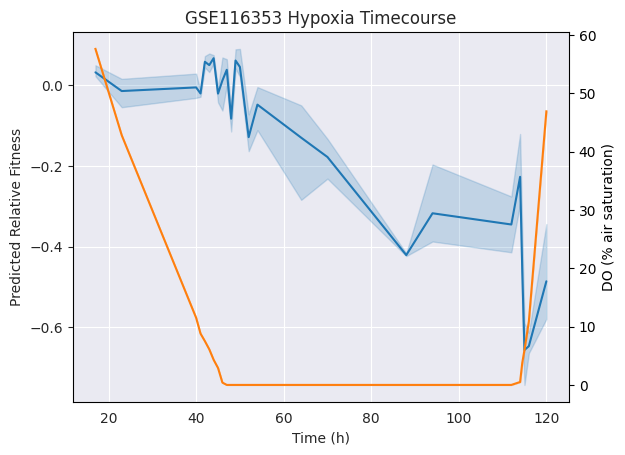

In [302]:
with sns.axes_style(style='darkgrid'):
    ax = sns.lineplot(
        data=testdata3_results_df.dropna(),
        x='time (h)', y='PredFitness',
        color='tab:blue'
    )
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Predicted Relative Fitness')
    ax.set_title('GSE116353 Hypoxia Timecourse')

ax2 = ax.twinx()

ax2 = sns.lineplot(
    data=testdata3_results_df.dropna(),
    x='time (h)', y='DO (% air saturation)',
    color='tab:orange', ax=ax2
);

Not too bad either... This is a more complicated experiment, so it makes sense we see a more complicated prediction. Pretty believable, and interesting! Probably not intuitive enough for good validation.